# Table of Contents
 <p><div class="lev1"><a href="#Computing-auto-covariance-function"><span class="toc-item-num">1&nbsp;&nbsp;</span>Computing auto-covariance function</a></div><div class="lev2"><a href="#Plots"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Plots</a></div><div class="lev1"><a href="#Fitting-Auto-covariance-function"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fitting Auto-covariance function</a></div><div class="lev2"><a href="#Specifying-kernel"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Specifying kernel</a></div><div class="lev2"><a href="#Optimization-ACF"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Optimization ACF</a></div><div class="lev1"><a href="#Fitting-GP"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fitting GP</a></div>

In [1]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Computing auto-covariance function

In [2]:
using TimeSeries
using DataFrames

In [3]:
station_data = readtable("data2015/725450.14990.processed.2015.2015.csv", 
    header=false,
    names=[:year, :month, :day, :hour, :min, :seconds, :temp])
station_data = station_data[!isnan(station_data[:temp]),:]    
station_ts = DateTime[DateTime(r[:year], r[:month], r[:day], r[:hour], r[:min], r[:seconds]) for r in eachrow(station_data)]
station_ts[1:10]

10-element Array{DateTime,1}:
 2015-01-01T00:52:00
 2015-01-01T01:52:00
 2015-01-01T02:52:00
 2015-01-01T03:52:00
 2015-01-01T04:52:00
 2015-01-01T05:52:00
 2015-01-01T06:52:00
 2015-01-01T07:52:00
 2015-01-01T08:52:00
 2015-01-01T09:52:00

In [4]:
# function ACF(times, values, bins)
#     npairs = zeros(Int, length(bins))
#     sqdiff_accum = zeros(Float64, length(bins))
#     n = length(times)
#     for (i, t1) in enumerate(times)
#         ibin = 1
#         for j in i:n
#             Δt = times[j] - t1
#             while Δt>bins[ibin]
#                 ibin += 1
#             end
#             npairs[ibin] += 1
#             sqdiff_accum[ibin] += (values[j]*values[i])
#         end
#     end
#     return sqdiff_accum ./ npairs
# end 
function variogram(times, values, bins)
    npairs = zeros(Int, length(bins))
    sqdiff_accum = zeros(Float64, length(bins))
    n = length(times)
    for (i, t1) in enumerate(times)
        ibin = 1
        for j in i:n
            Δt = times[j] - t1
            while Δt>bins[ibin]
                ibin += 1
            end
            npairs[ibin] += 1
            sqdiff_accum[ibin] += (values[j]-values[i])^2
        end
    end
    return sqdiff_accum ./ (npairs.*2)
end
function ACF(times, values, bins)
    return var(values) .- variogram(times, values, bins)
end

ACF (generic function with 1 method)

In [5]:
_bins = collect(Dates.Hour(0):Dates.Hour(1):Dates.Hour(400*24))
station_ACF = ACF(station_ts, station_data[:temp].-mean(station_data[:temp]), _bins)
station_variog = variogram(station_ts, station_data[:temp].-mean(station_data[:temp]), _bins)

9601-element Array{Float64,1}:
   0.0     
   0.555185
   1.6863  
   3.28764 
   5.23111 
   7.30622 
   9.5084  
  11.6131  
  13.4964  
  15.1637  
  16.5549  
  17.7271  
  18.4046  
   ⋮       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       

## Plots

In [6]:
bins_hours = convert(Vector{Float64}, _bins);
bins_days = bins_hours/24;

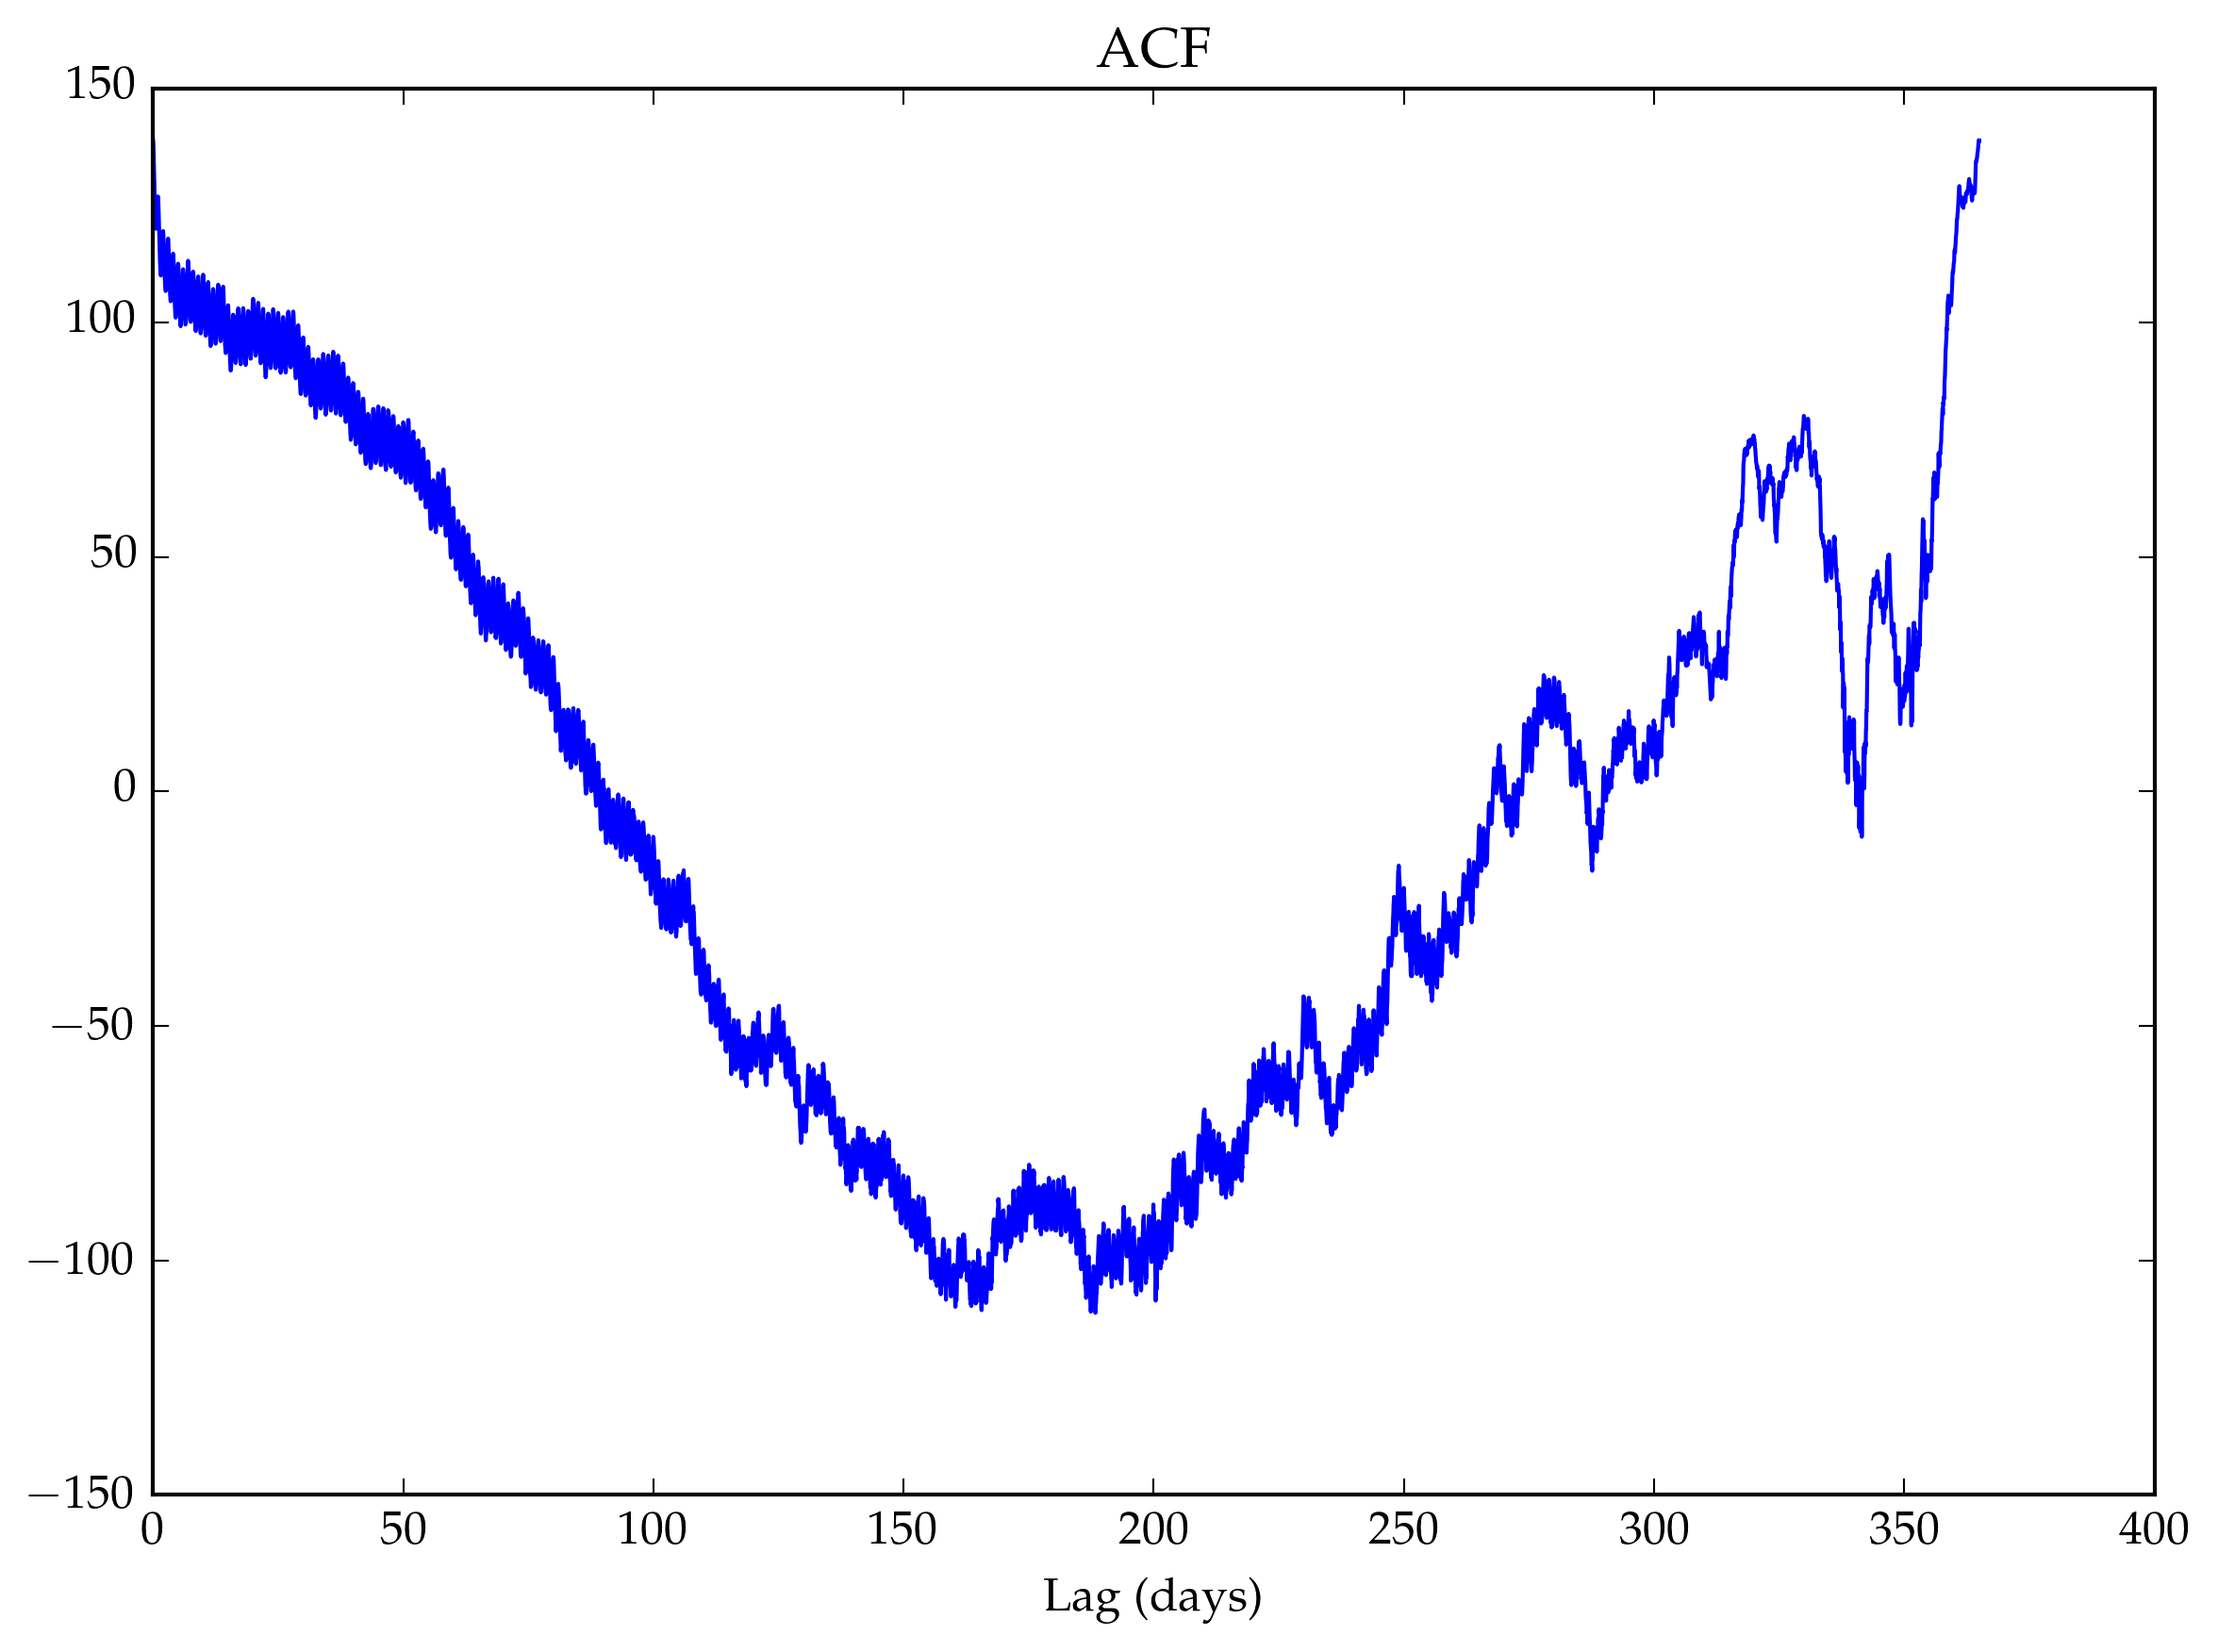

In [7]:
plt.plot(bins_days, station_ACF)
plt.xlabel("Lag (days)")
plt.title("ACF")
;

/Users/imolk/bin/venv_jupyter/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


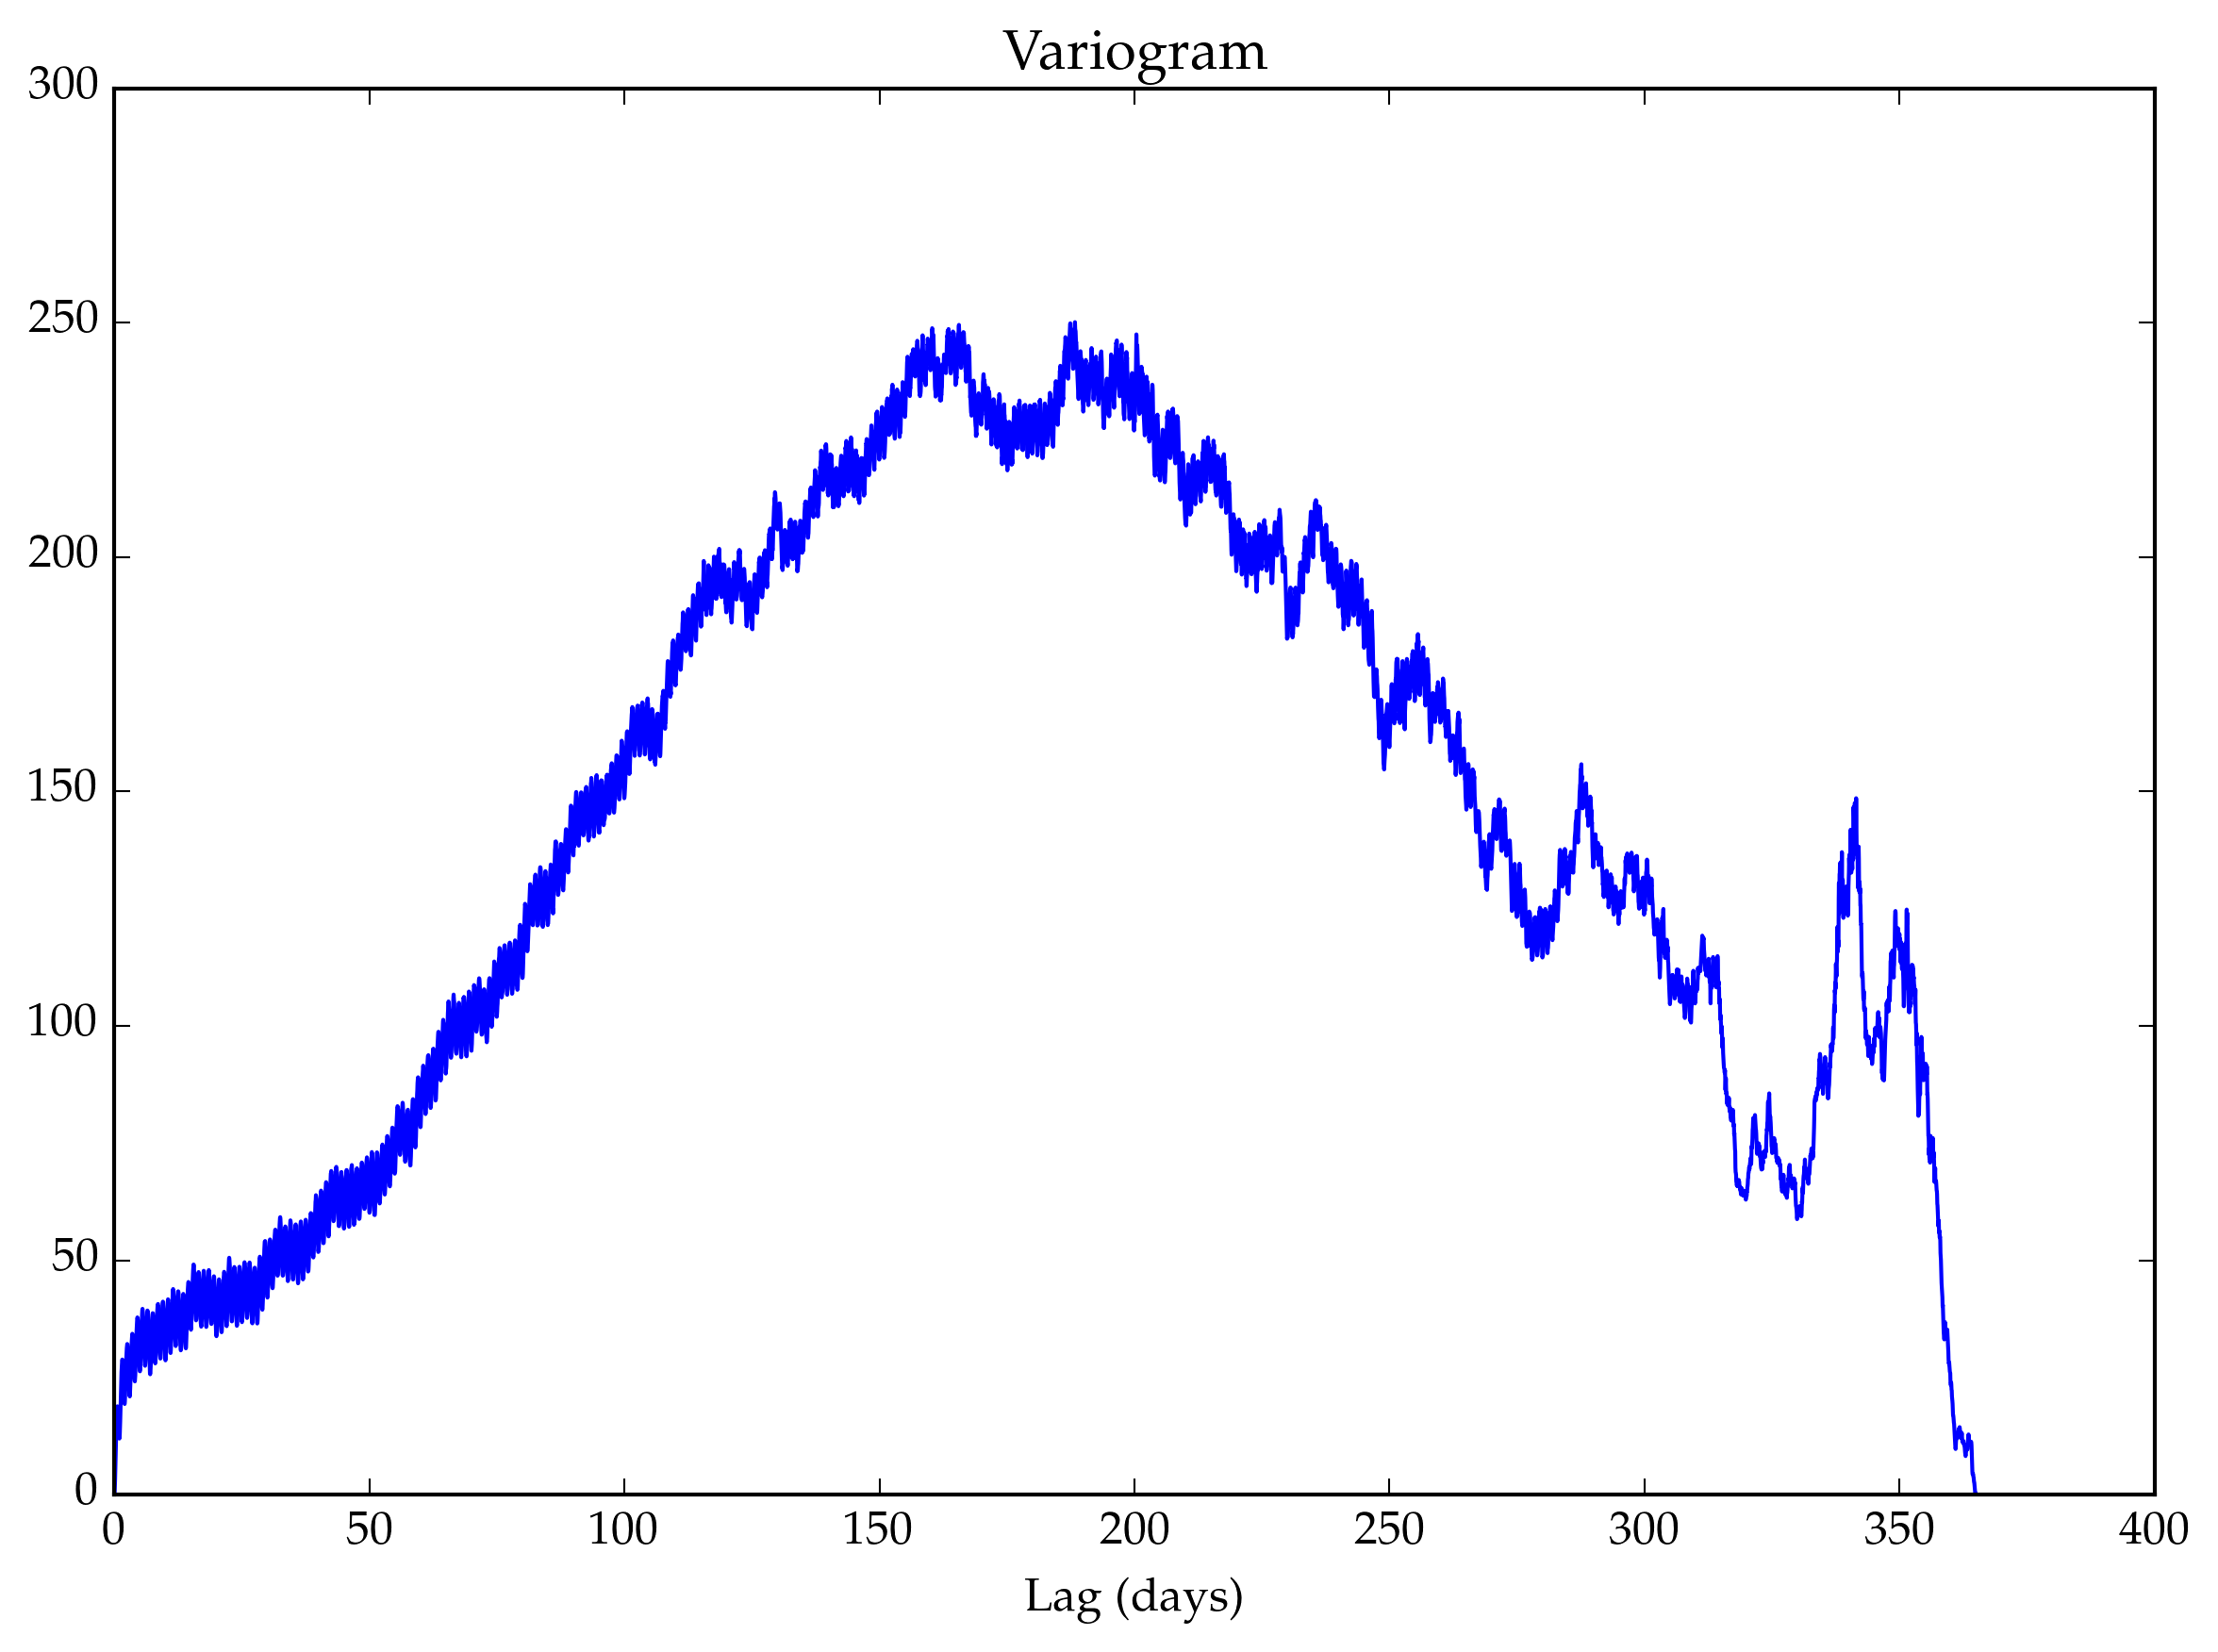

In [8]:
plt.plot(bins_days, station_variog)
plt.title("Variogram")
plt.xlabel("Lag (days)")
;

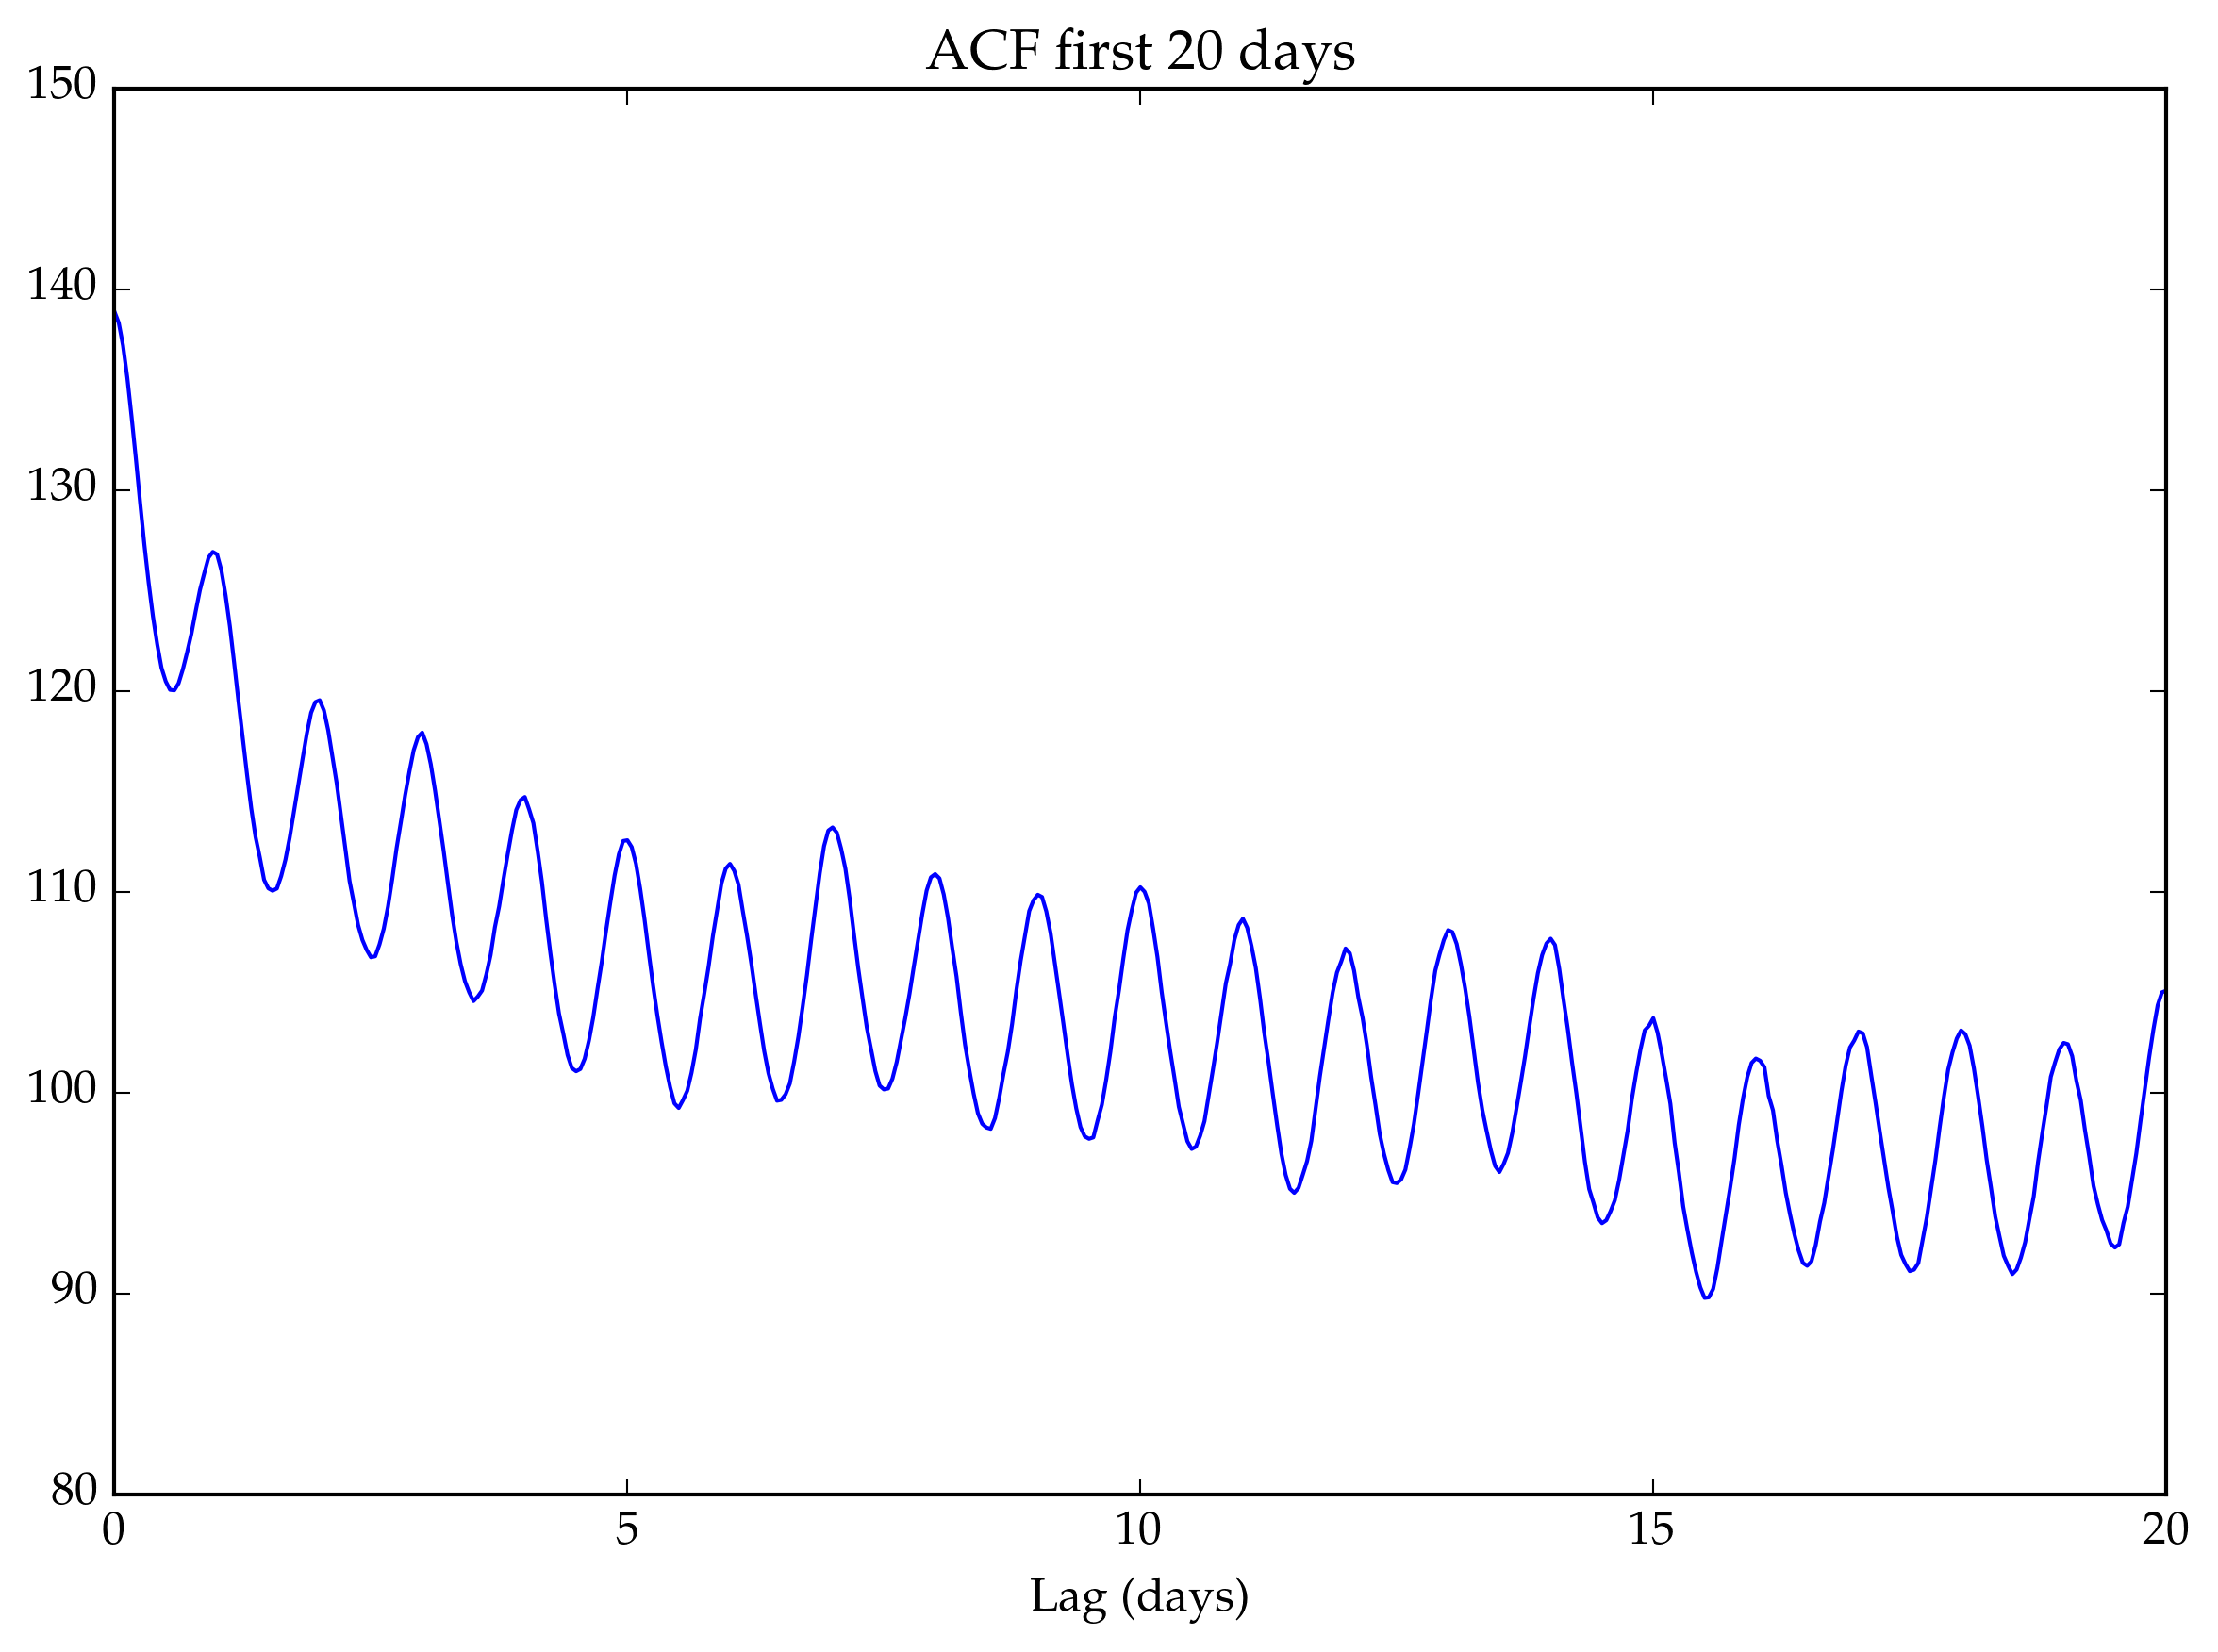

In [9]:
plt.plot(bins_days, station_ACF)
plt.xlim(0,20)
plt.ylim(80,150)
plt.title("ACF first 20 days")
plt.xlabel("Lag (days)")
;

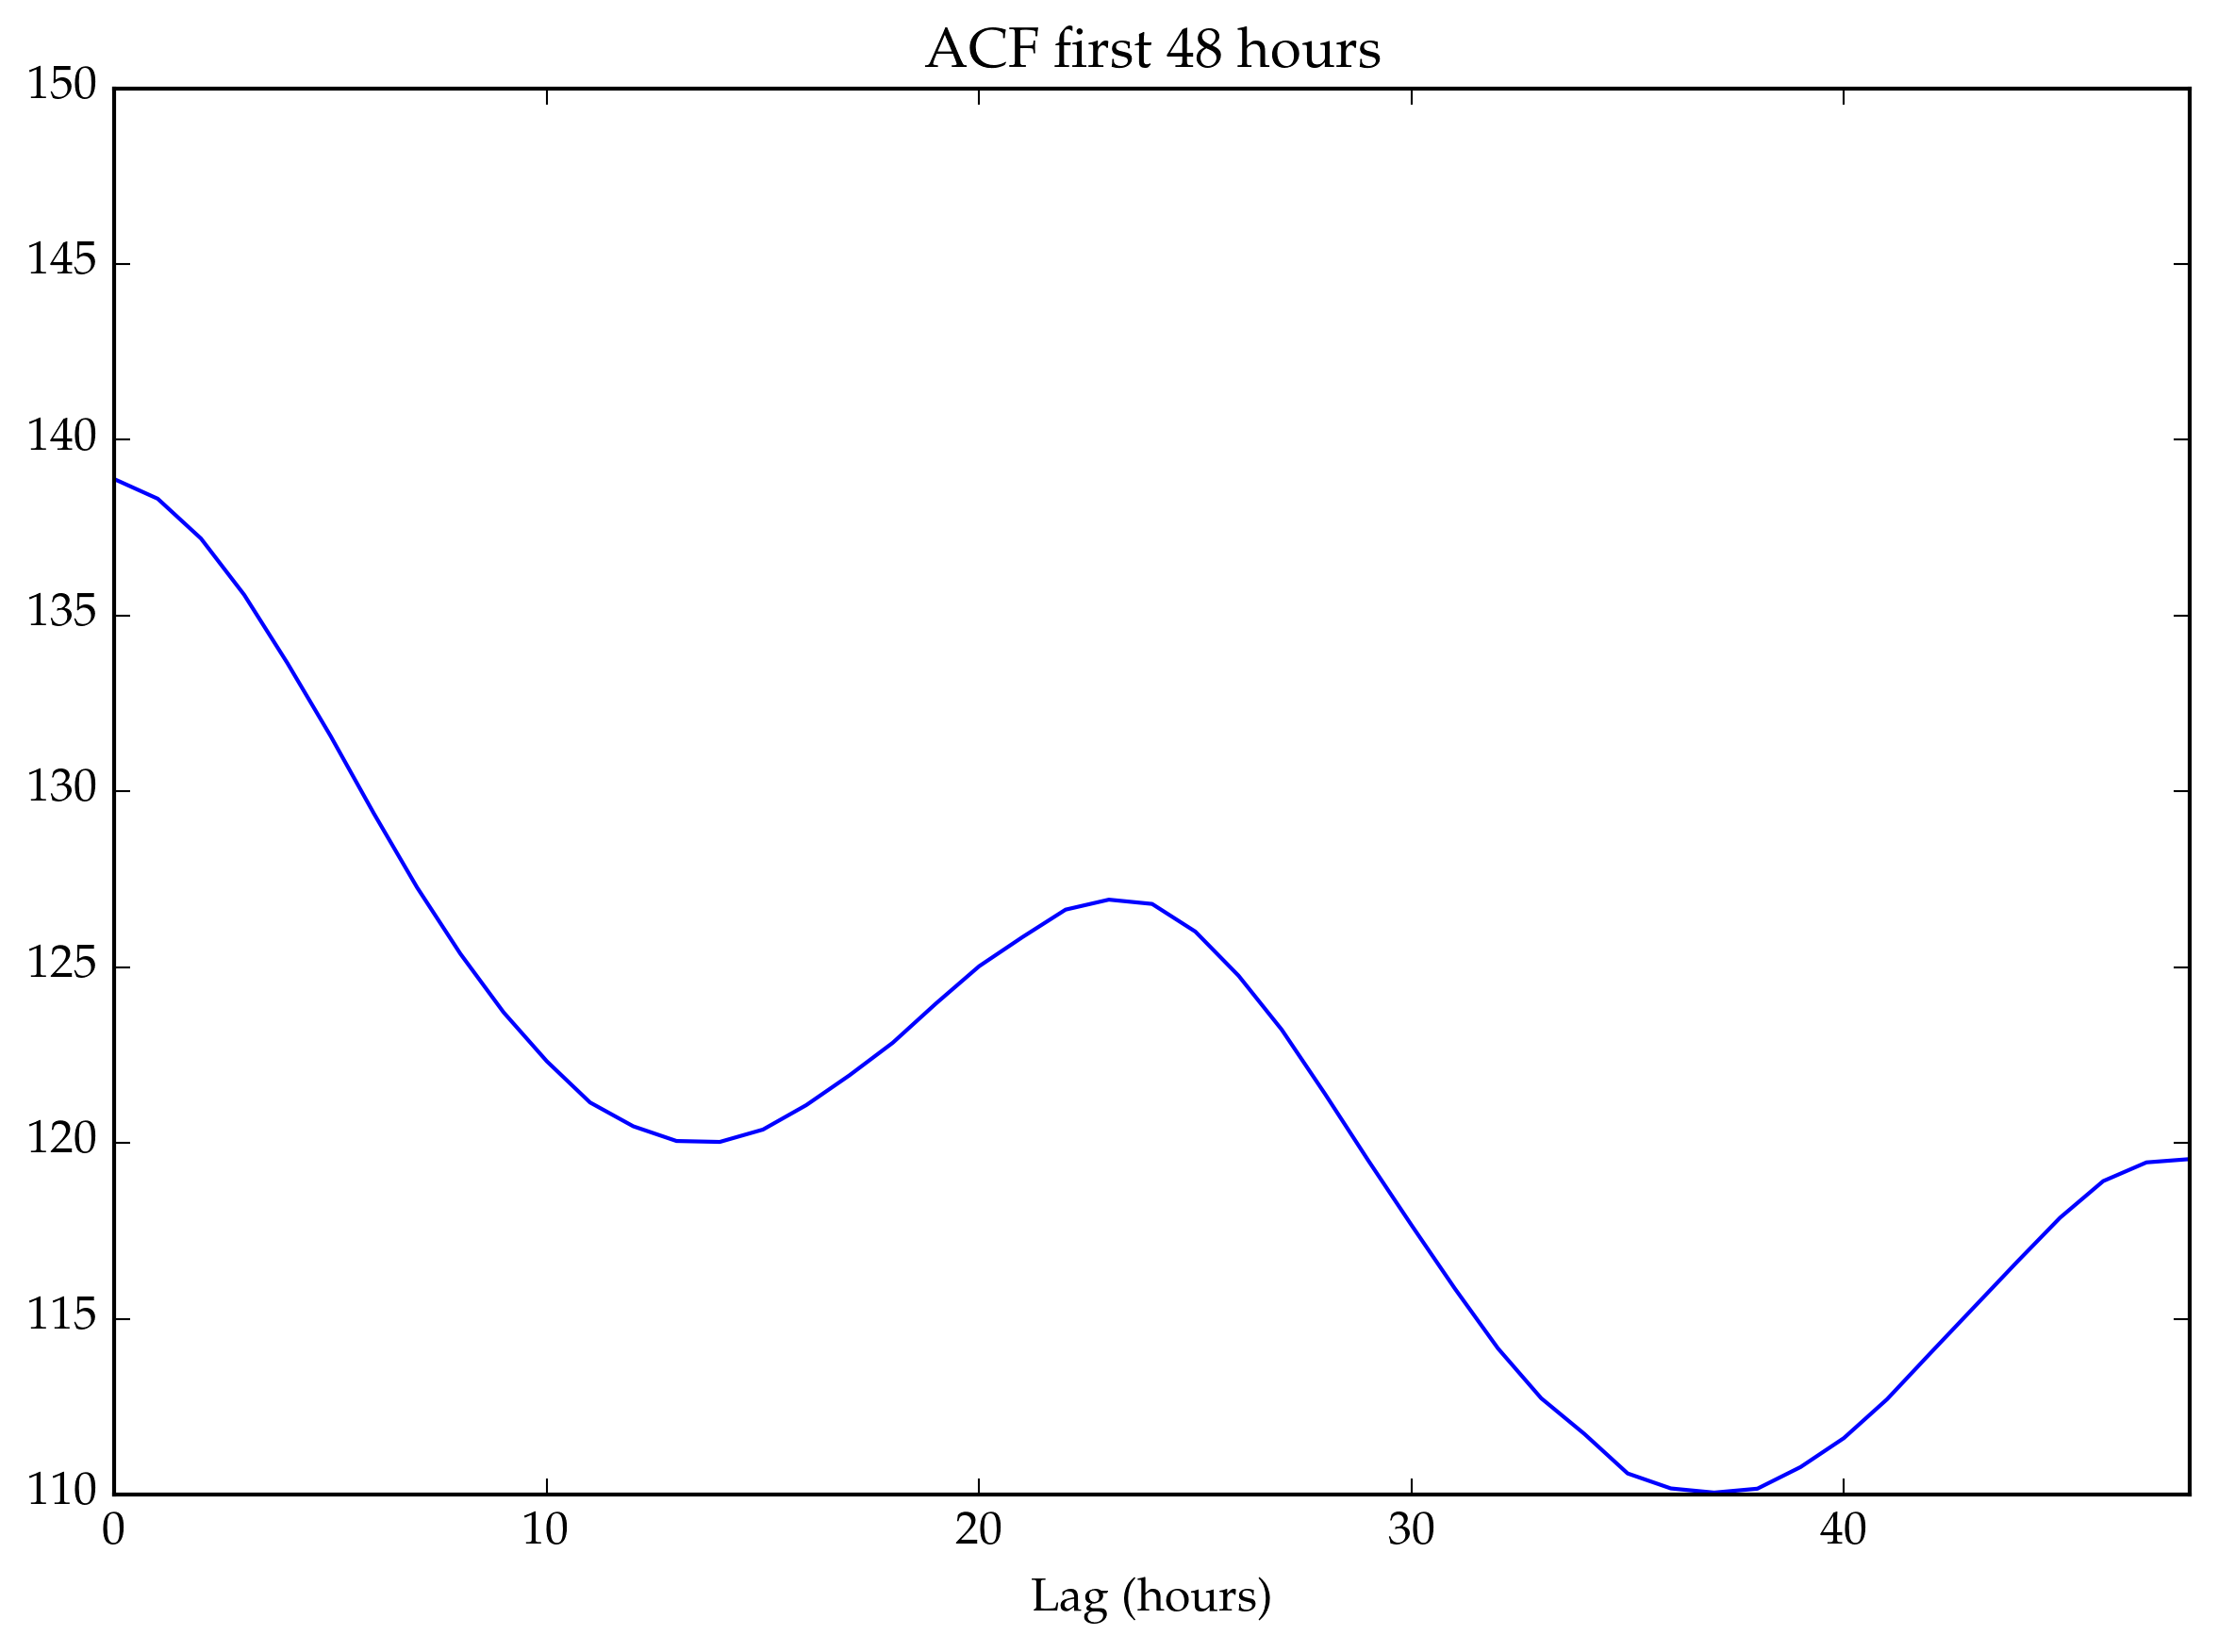

In [10]:
plt.plot(bins_hours, station_ACF)
plt.xlim(0,48)
plt.ylim(110,150)
plt.title("ACF first 48 hours")
plt.xlabel("Lag (hours)")
;

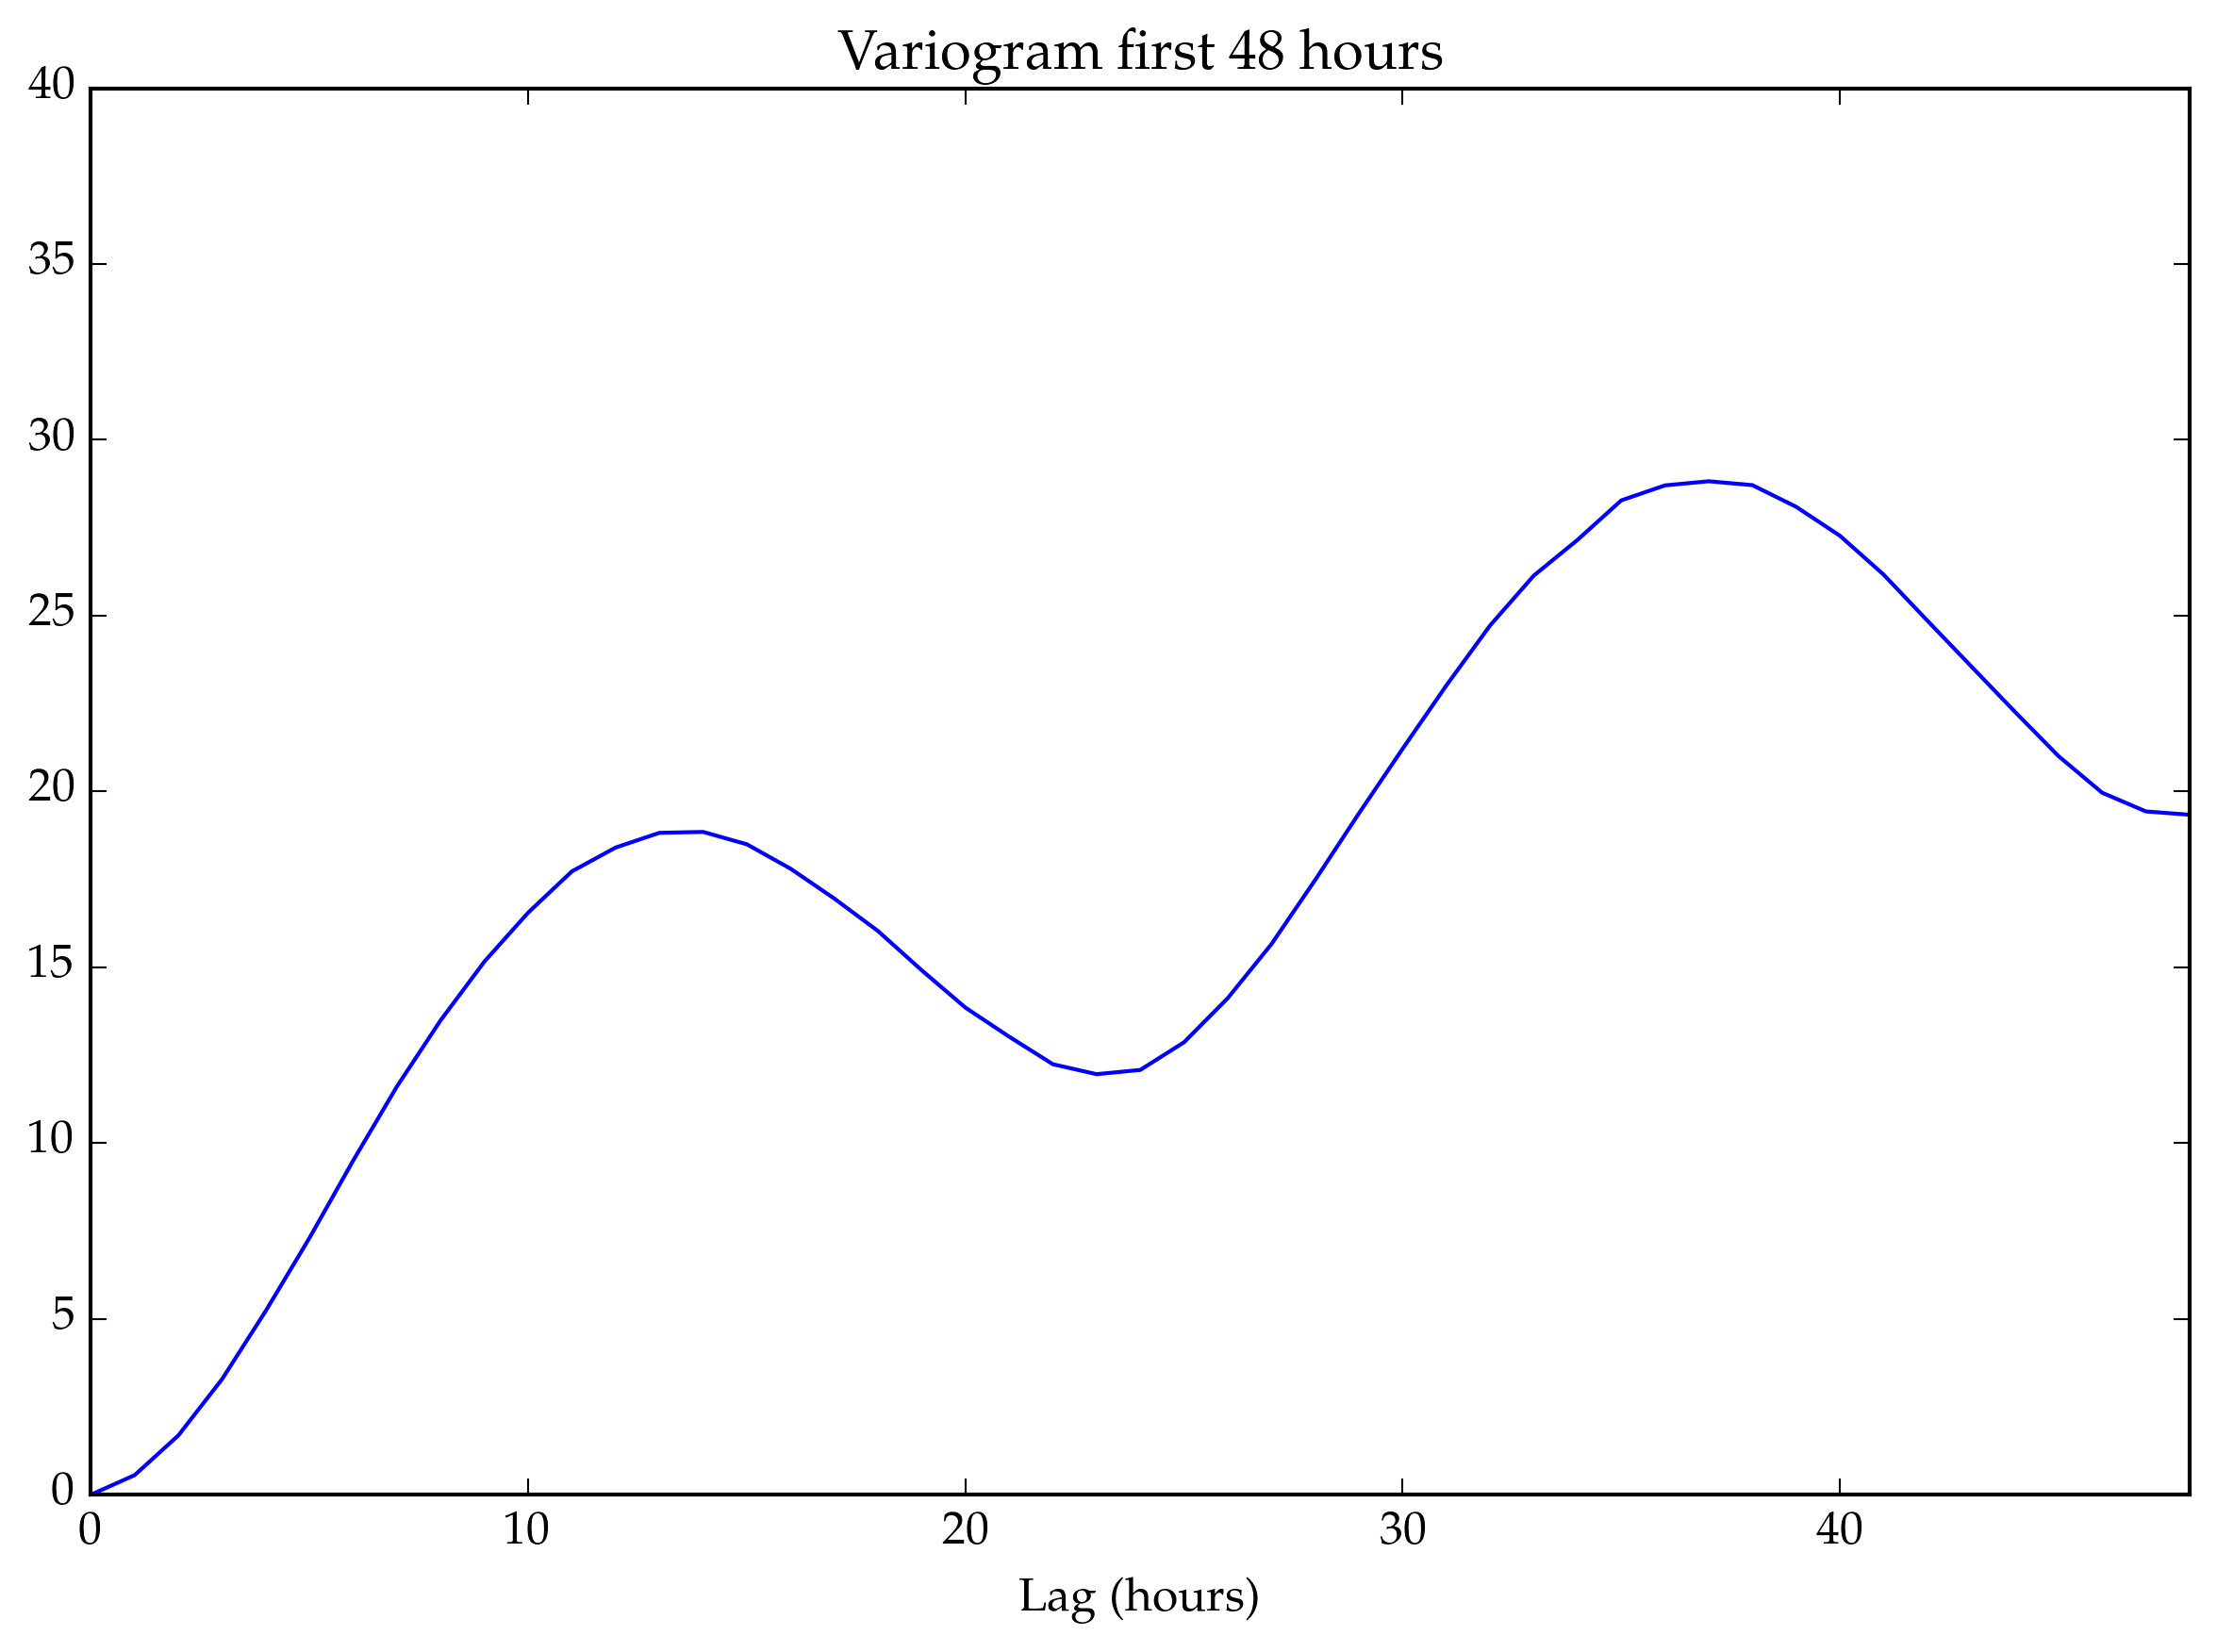

In [11]:
plt.plot(bins_hours, station_variog)
plt.xlim(0,48)
plt.ylim(0,40)
plt.title("Variogram first 48 hours")
plt.xlabel("Lag (hours)")
;

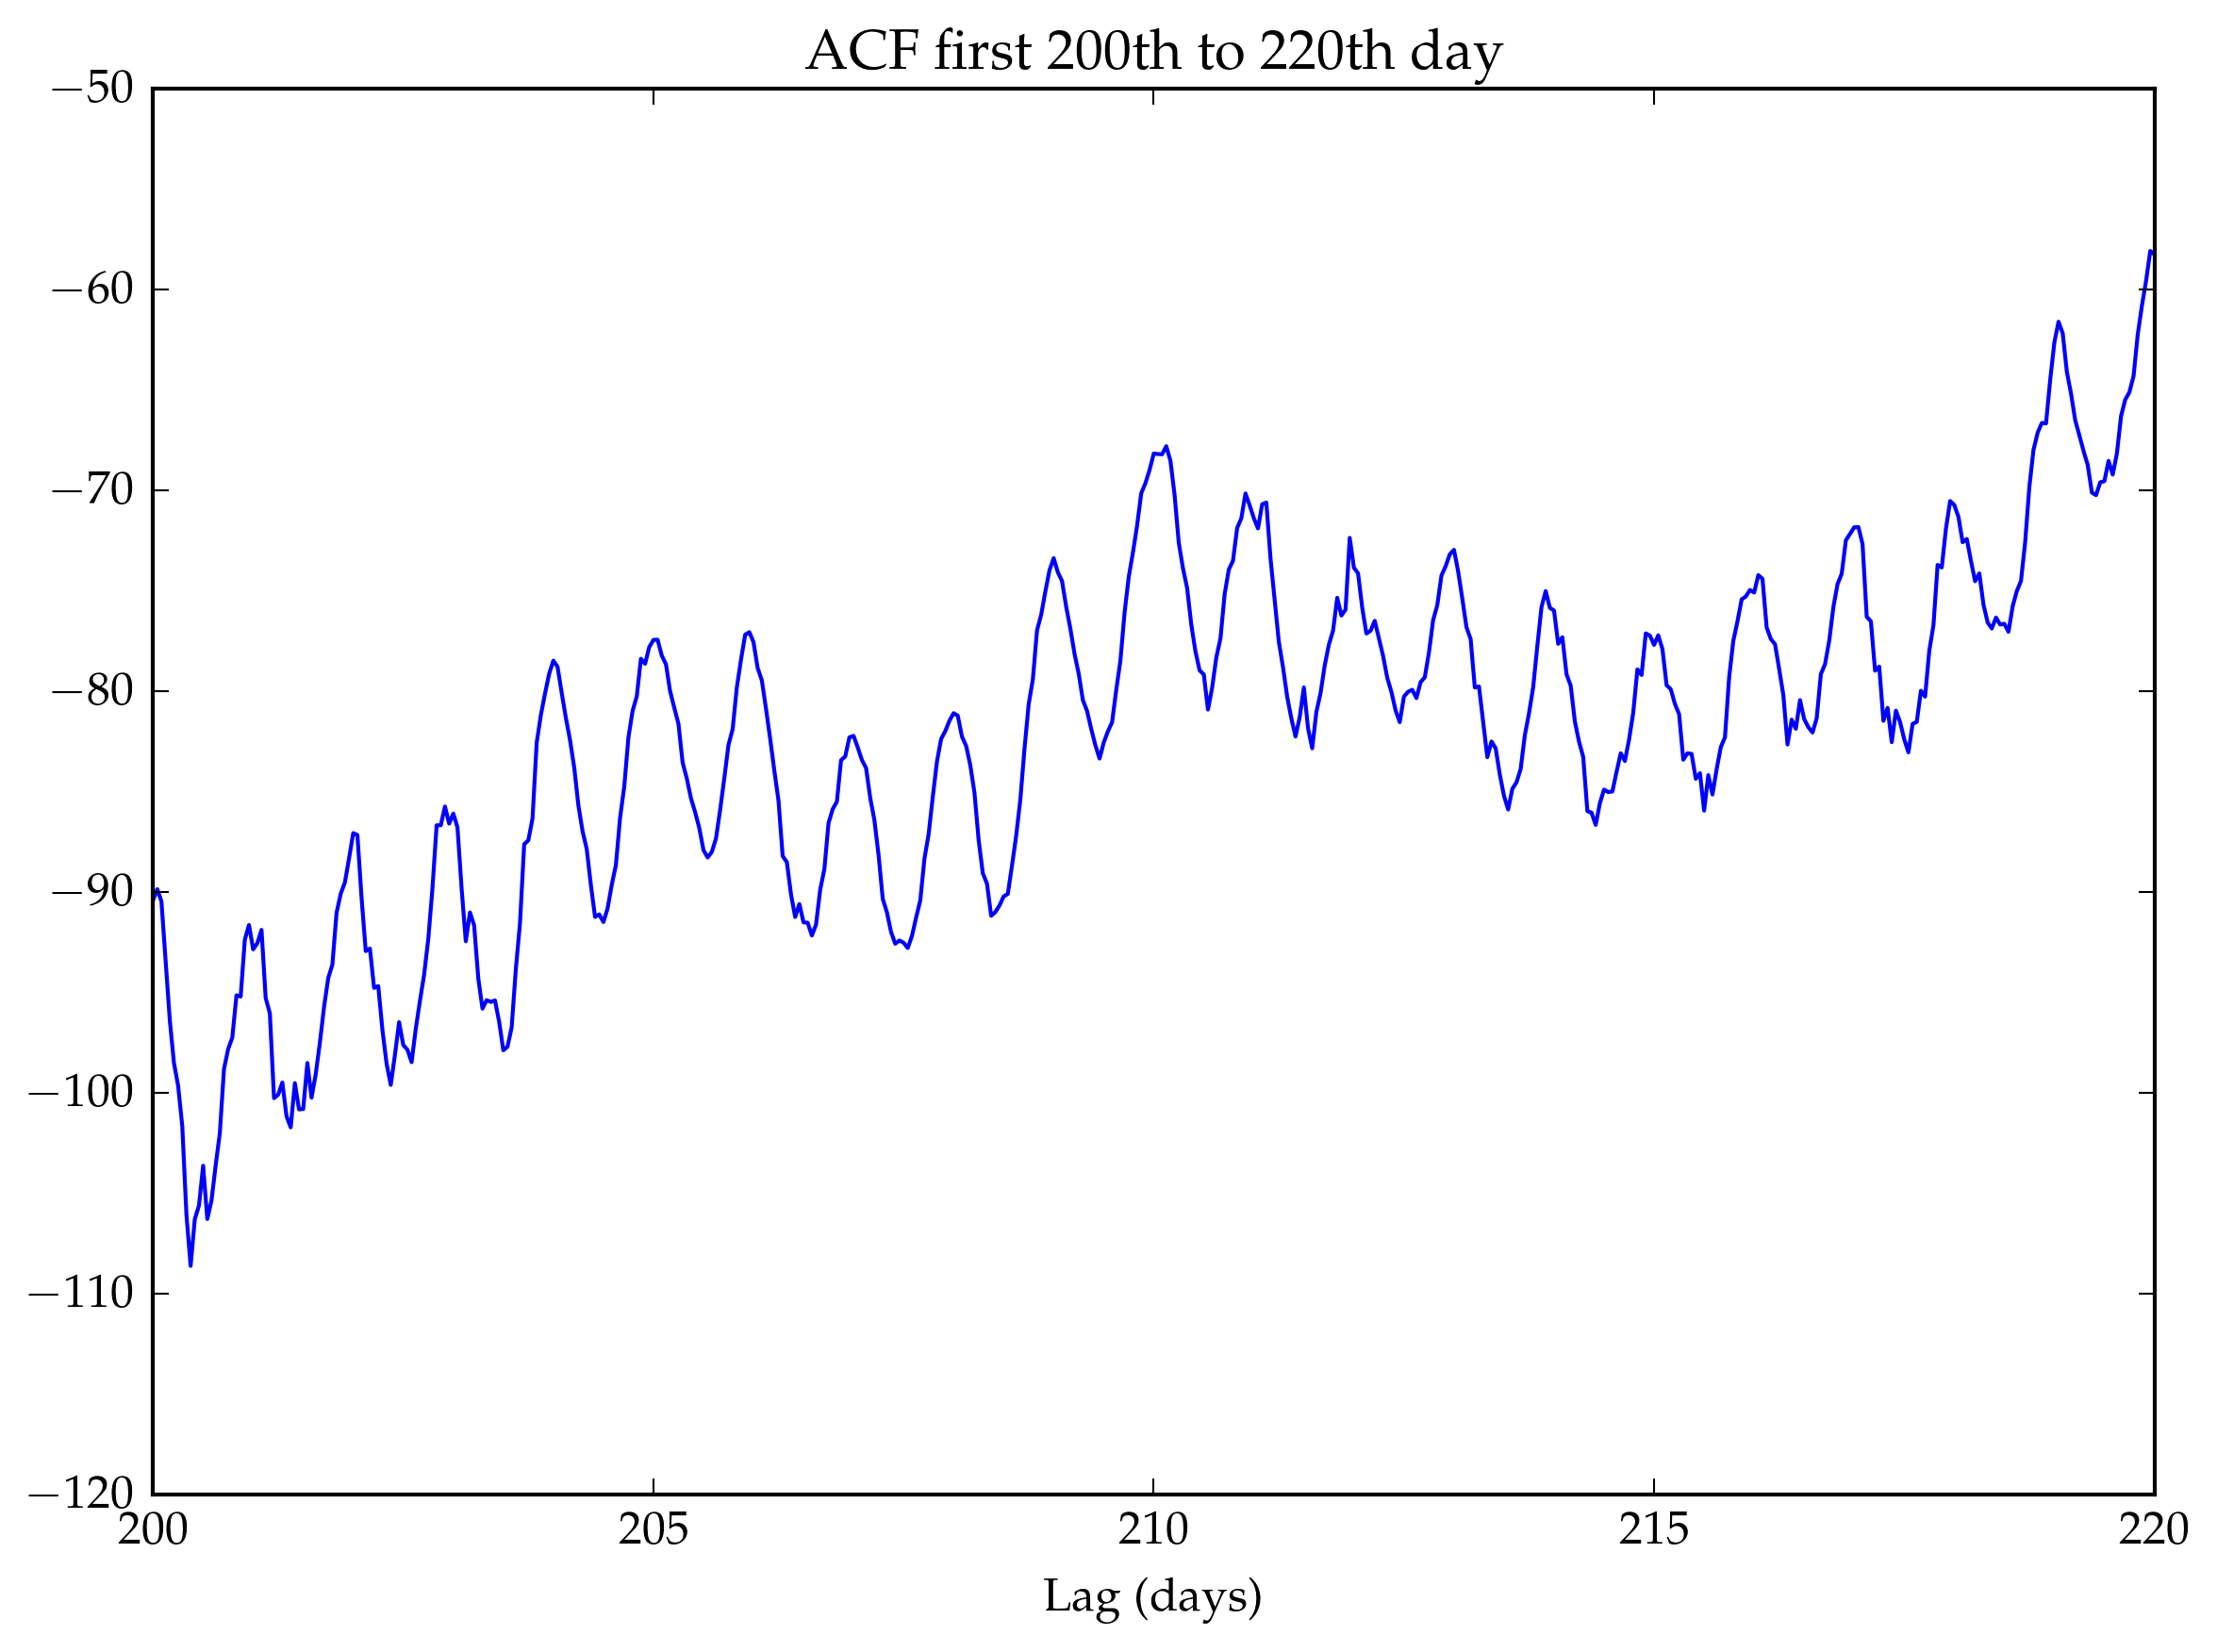

In [12]:
plt.plot(bins_days, station_ACF)
plt.xlim(200,220)
plt.ylim(-120,-50)
plt.title("ACF first 200th to 220th day")
plt.xlabel("Lag (days)")
;

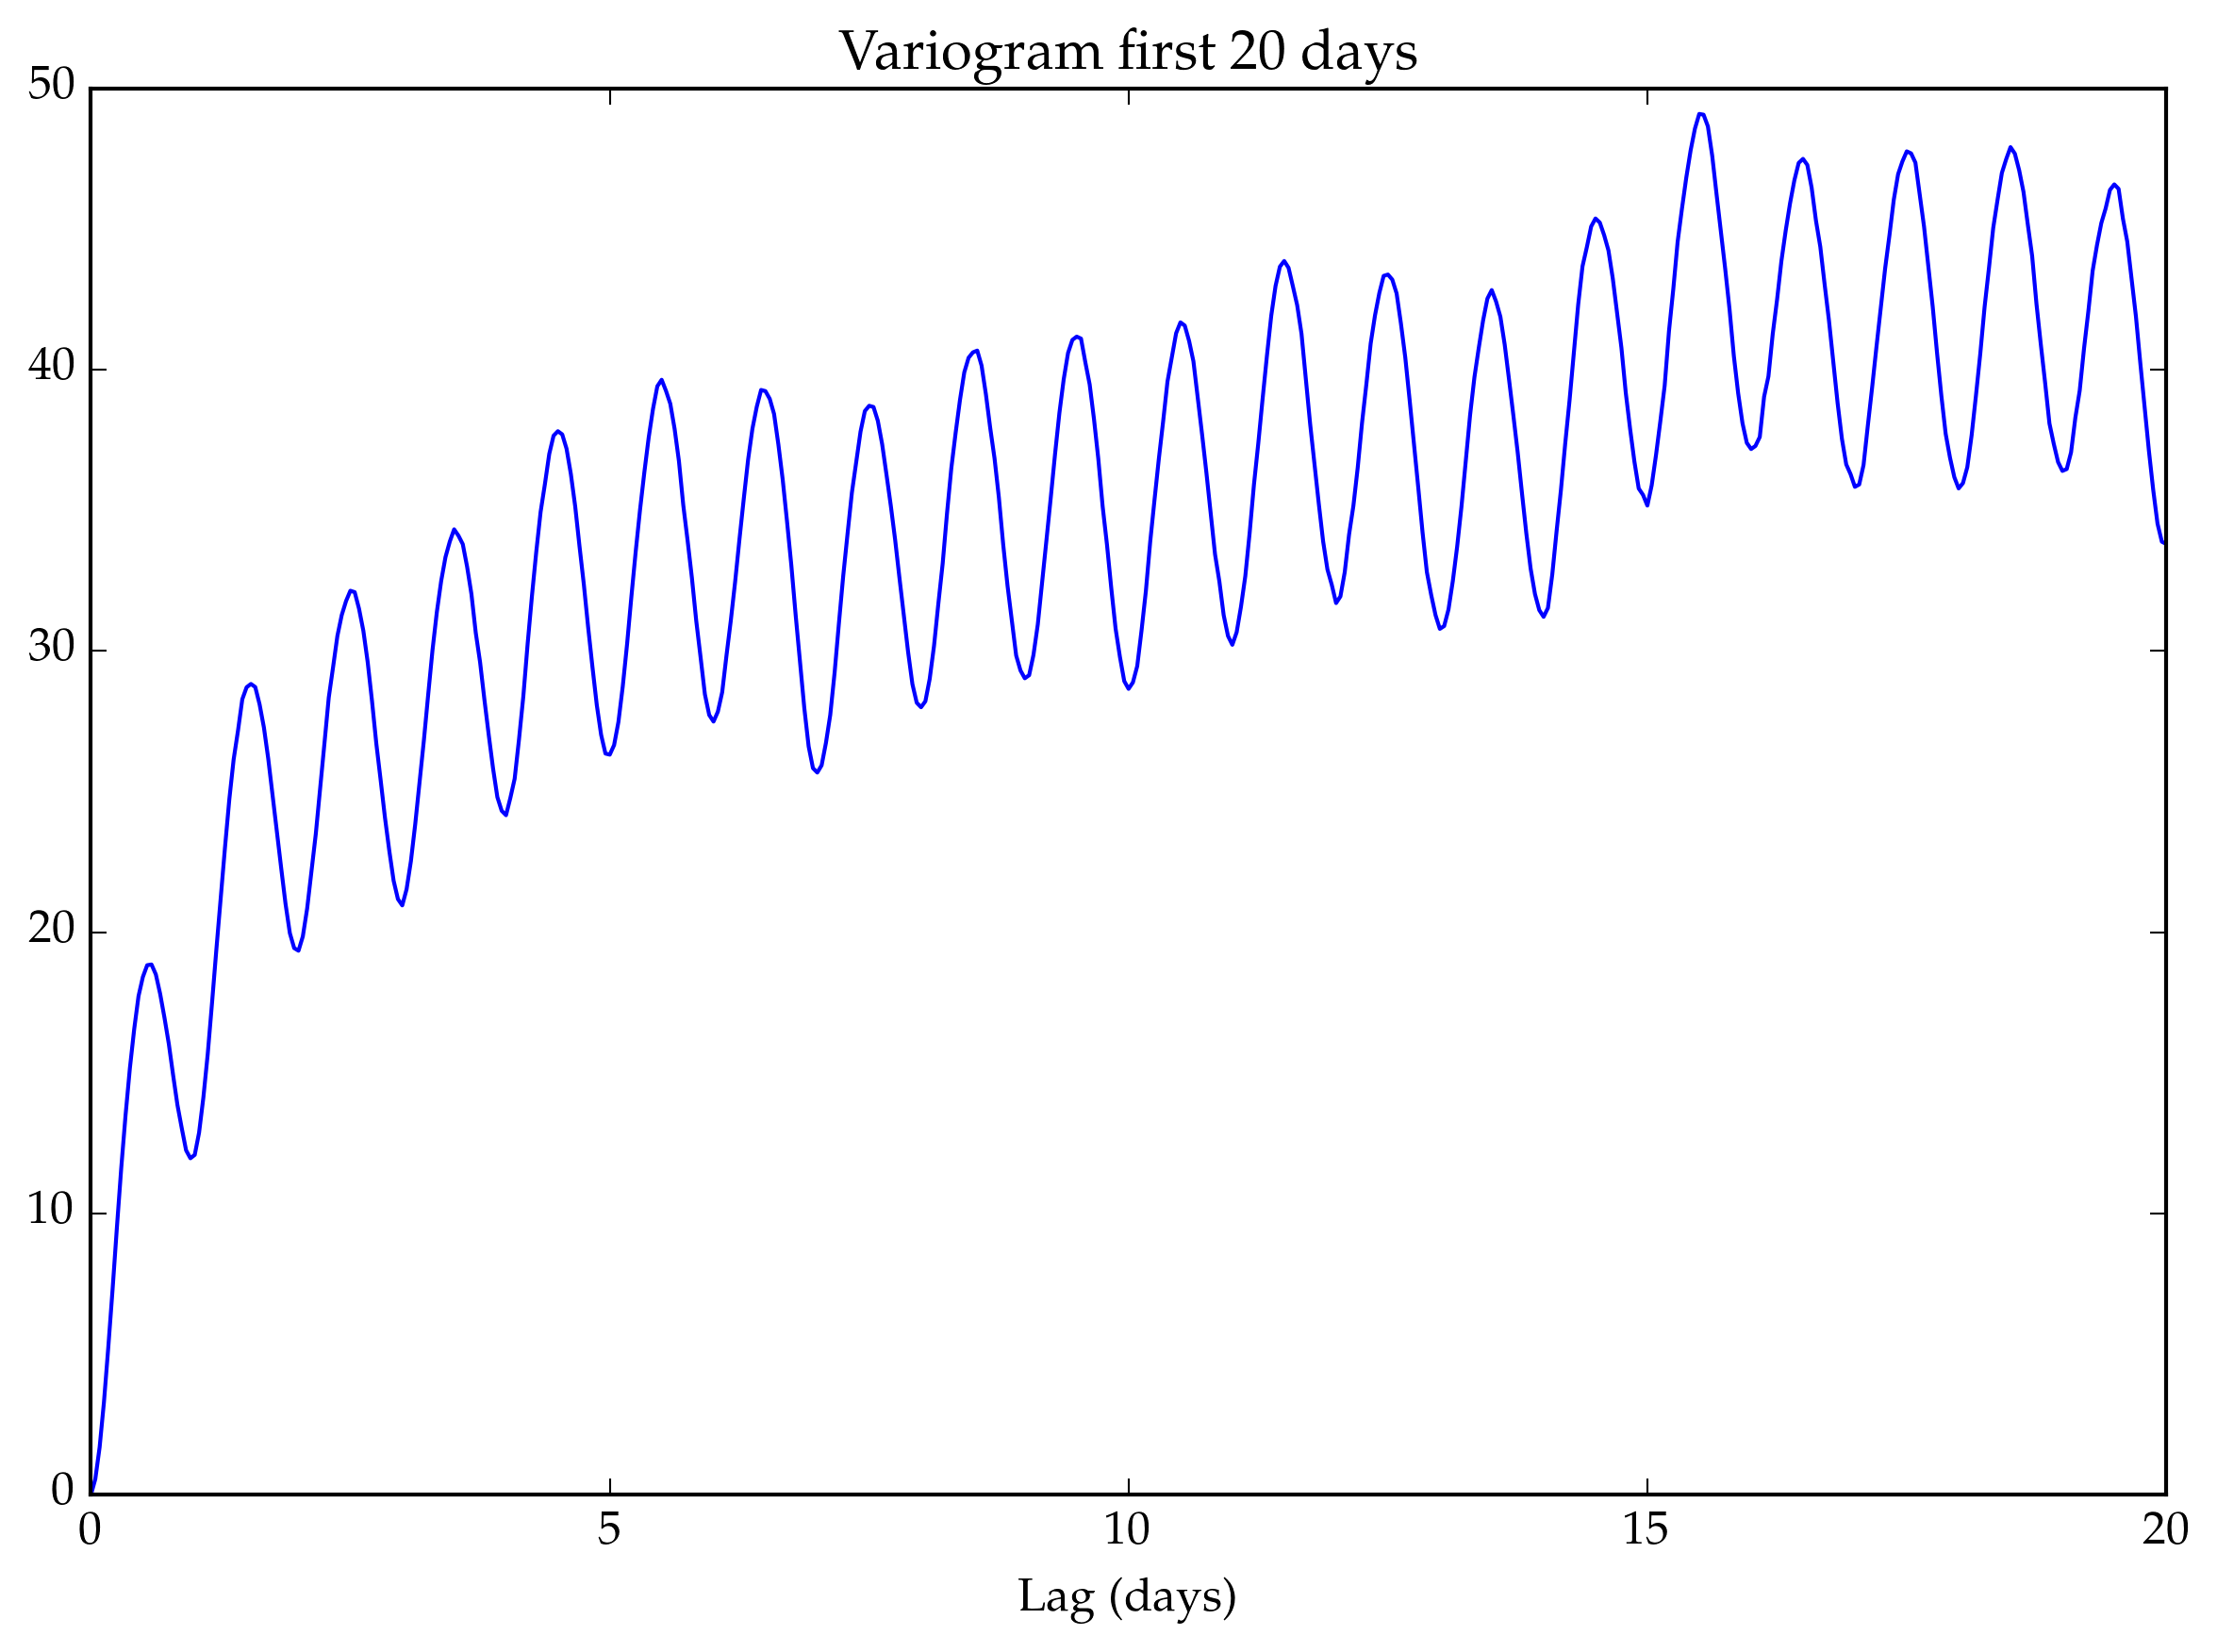

In [13]:
plt.plot(bins_days, station_variog)
plt.xlim(0,20)
plt.ylim(0,50)
plt.title("Variogram first 20 days")
plt.xlabel("Lag (days)")
;

# Fitting Auto-covariance function

In [14]:
import Gadfly
import GaussianProcesses
GP = GaussianProcesses;
import Optim

## Specifying kernel

In [15]:
k1 = GP.Periodic(log(0.5), log(√(10.0)), log(24.0))
k2 = GP.SE(log(5.0*24), log(√40.0))
k3 = GP.SE(log(200.0*24), log(√80.0))
k4 = GP.SE(log(0.5*24), log(√10.0))
k5 = GP.Noise(log(√1.0))
k6 = GP.SE(log(20.0*24), 0.0)
_k=(k1+k2+k3+k4+k5)*k6

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.5.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:38
 in + at operators.jl:103
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /Users/imolk/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /Users/imolk/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[15], in expression starting on line 7
 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.5.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:38
 in + at operators.jl:103
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /Users/imolk/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /Users/imolk/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[15], in expression starting on line 7
 in depwarn at deprecated.jl:73
 in oldstyle_vcat_

Type: GaussianProcesses.ProdKernel
  Type: GaussianProcesses.SumKernel
    Type: GaussianProcesses.Periodic, Params: [-0.6931471805599453,1.151292546497023,3.1780538303479458]
    Type: GaussianProcesses.SEIso, Params: [4.787491742782046,1.8444397270569681]
    Type: GaussianProcesses.SEIso, Params: [8.476371196895983,2.191013317336941]
    Type: GaussianProcesses.SEIso, Params: [2.4849066497880004,1.151292546497023]
    Type: GaussianProcesses.Noise, Params: [0.0]
  Type: GaussianProcesses.SEIso, Params: [6.173786103901937,0.0]


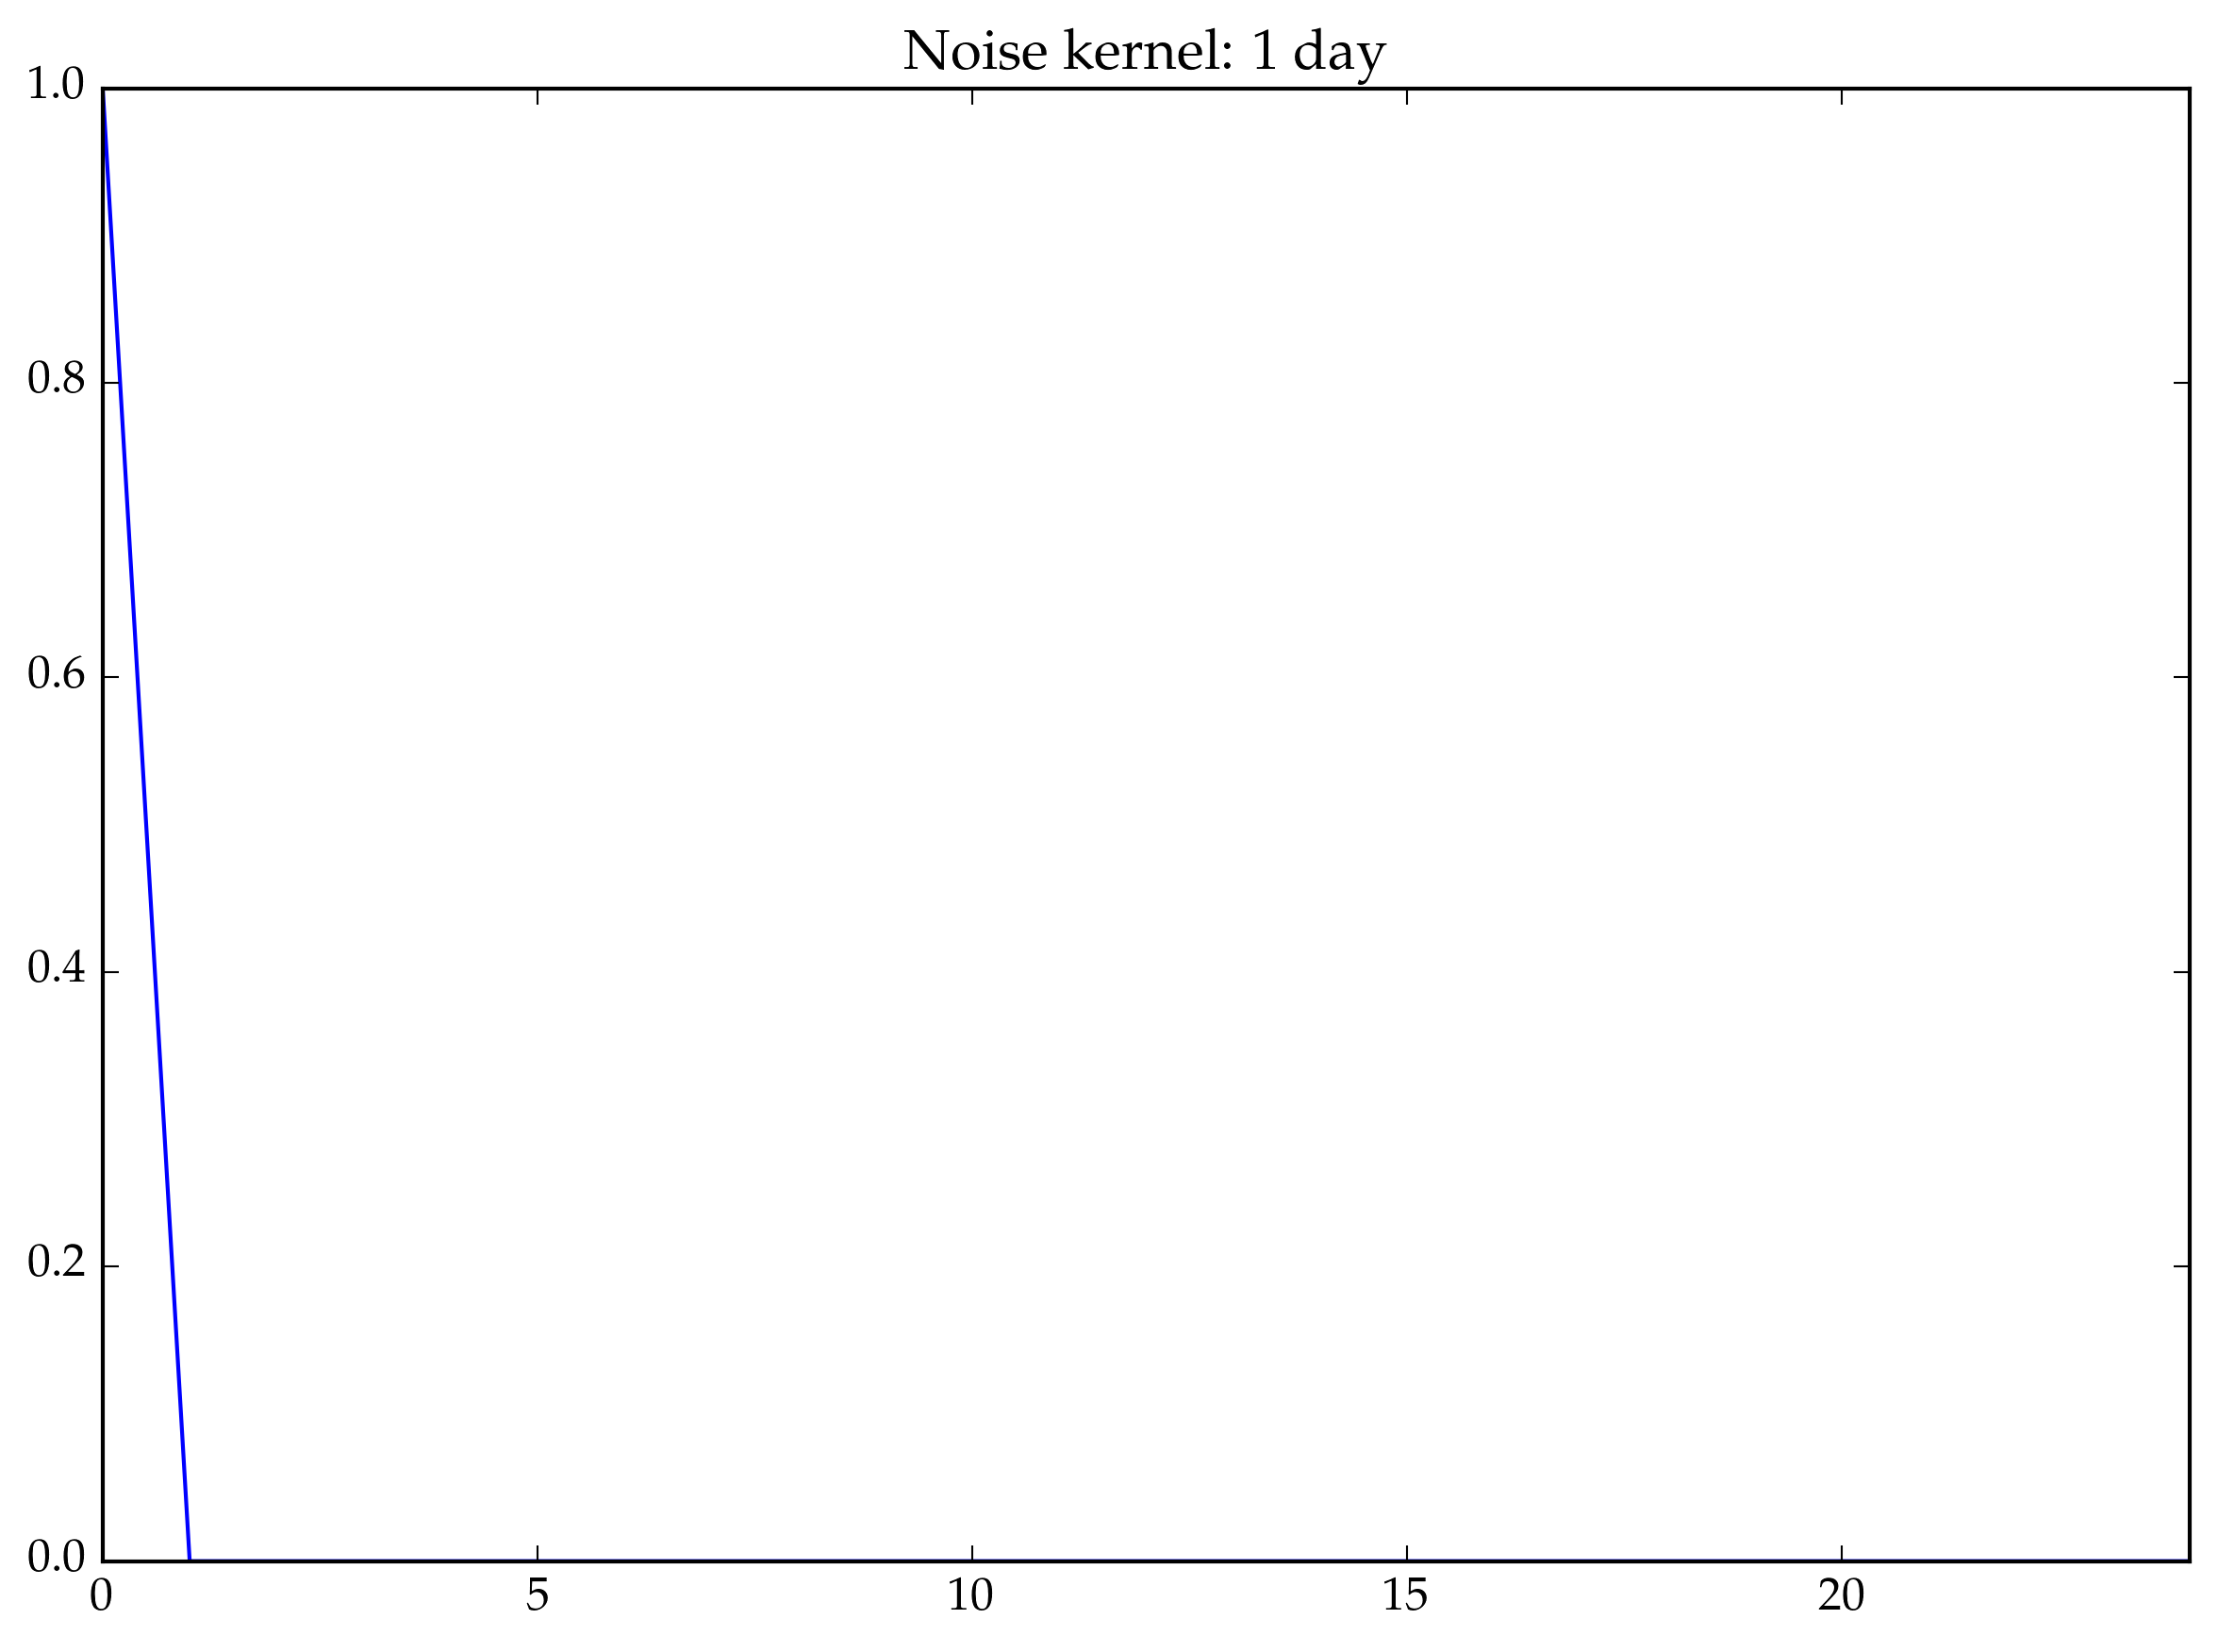

In [16]:
_x = collect(0:24.0)
plt.plot(_x, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), k5))
plt.xlim(0,24)
plt.title("Noise kernel: 1 day")
;

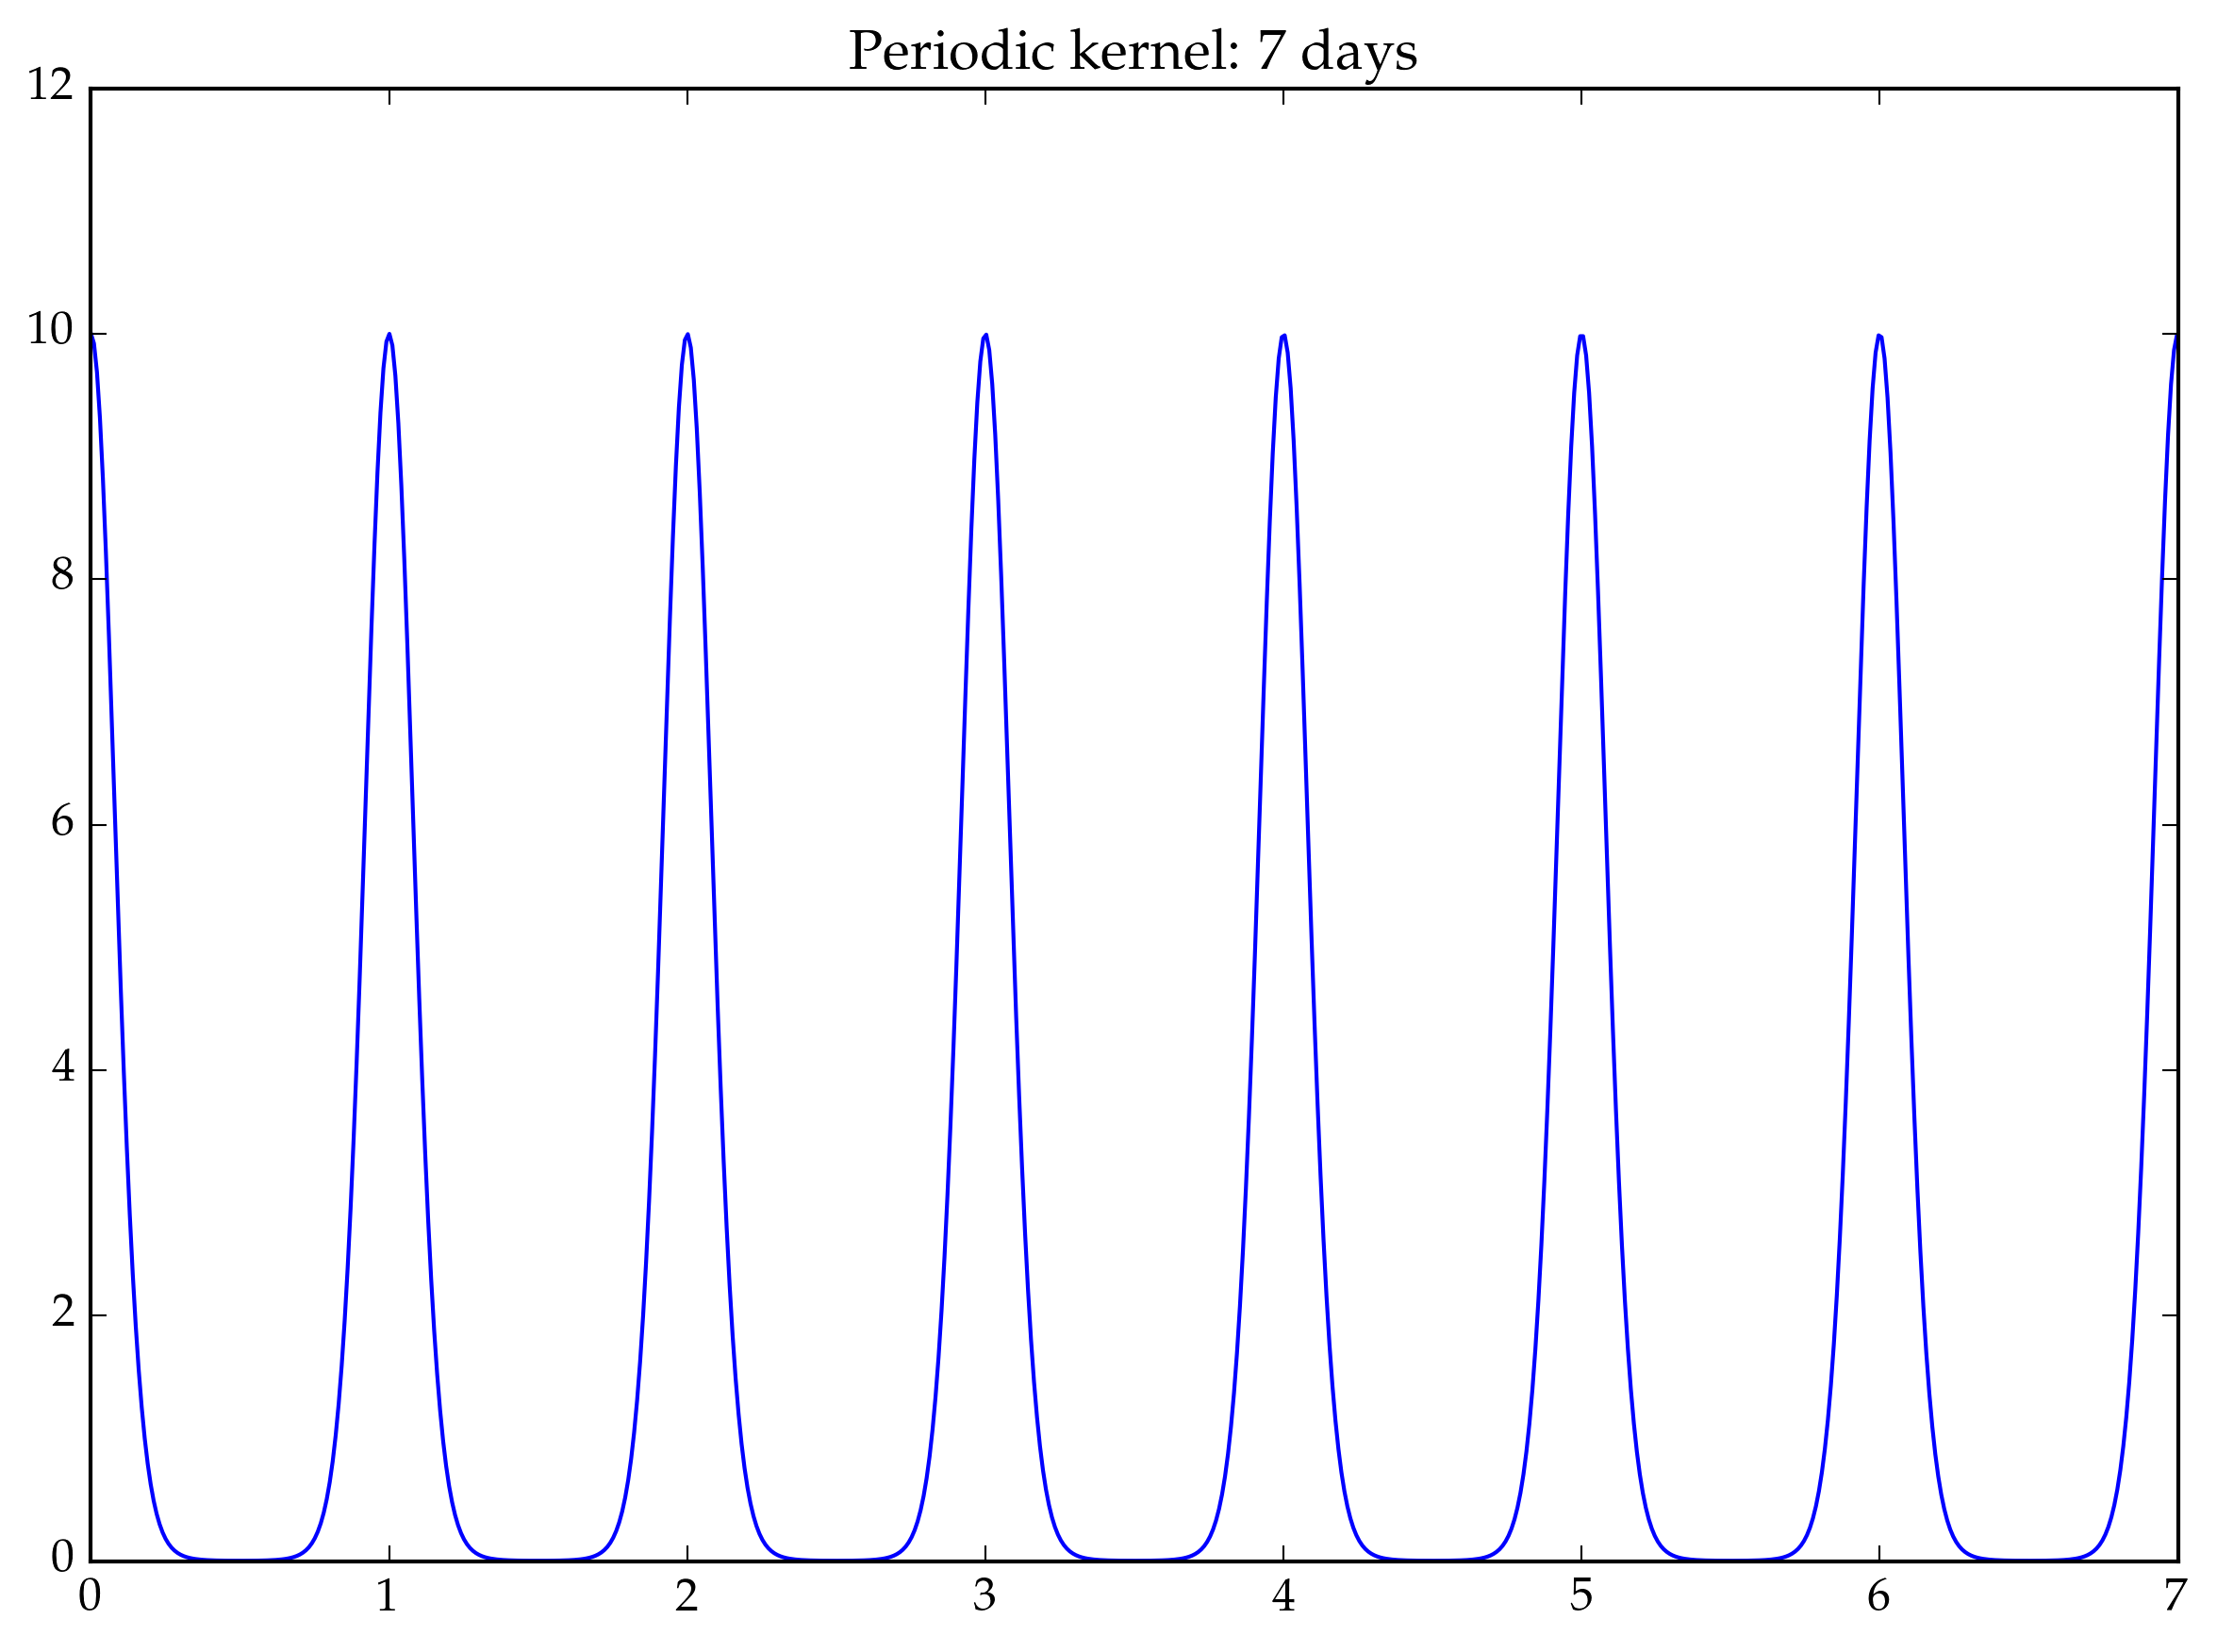

In [17]:
_x = linspace(0,24*10,1000)
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), k1))
plt.xlim(0,7)
plt.title("Periodic kernel: 7 days")
;

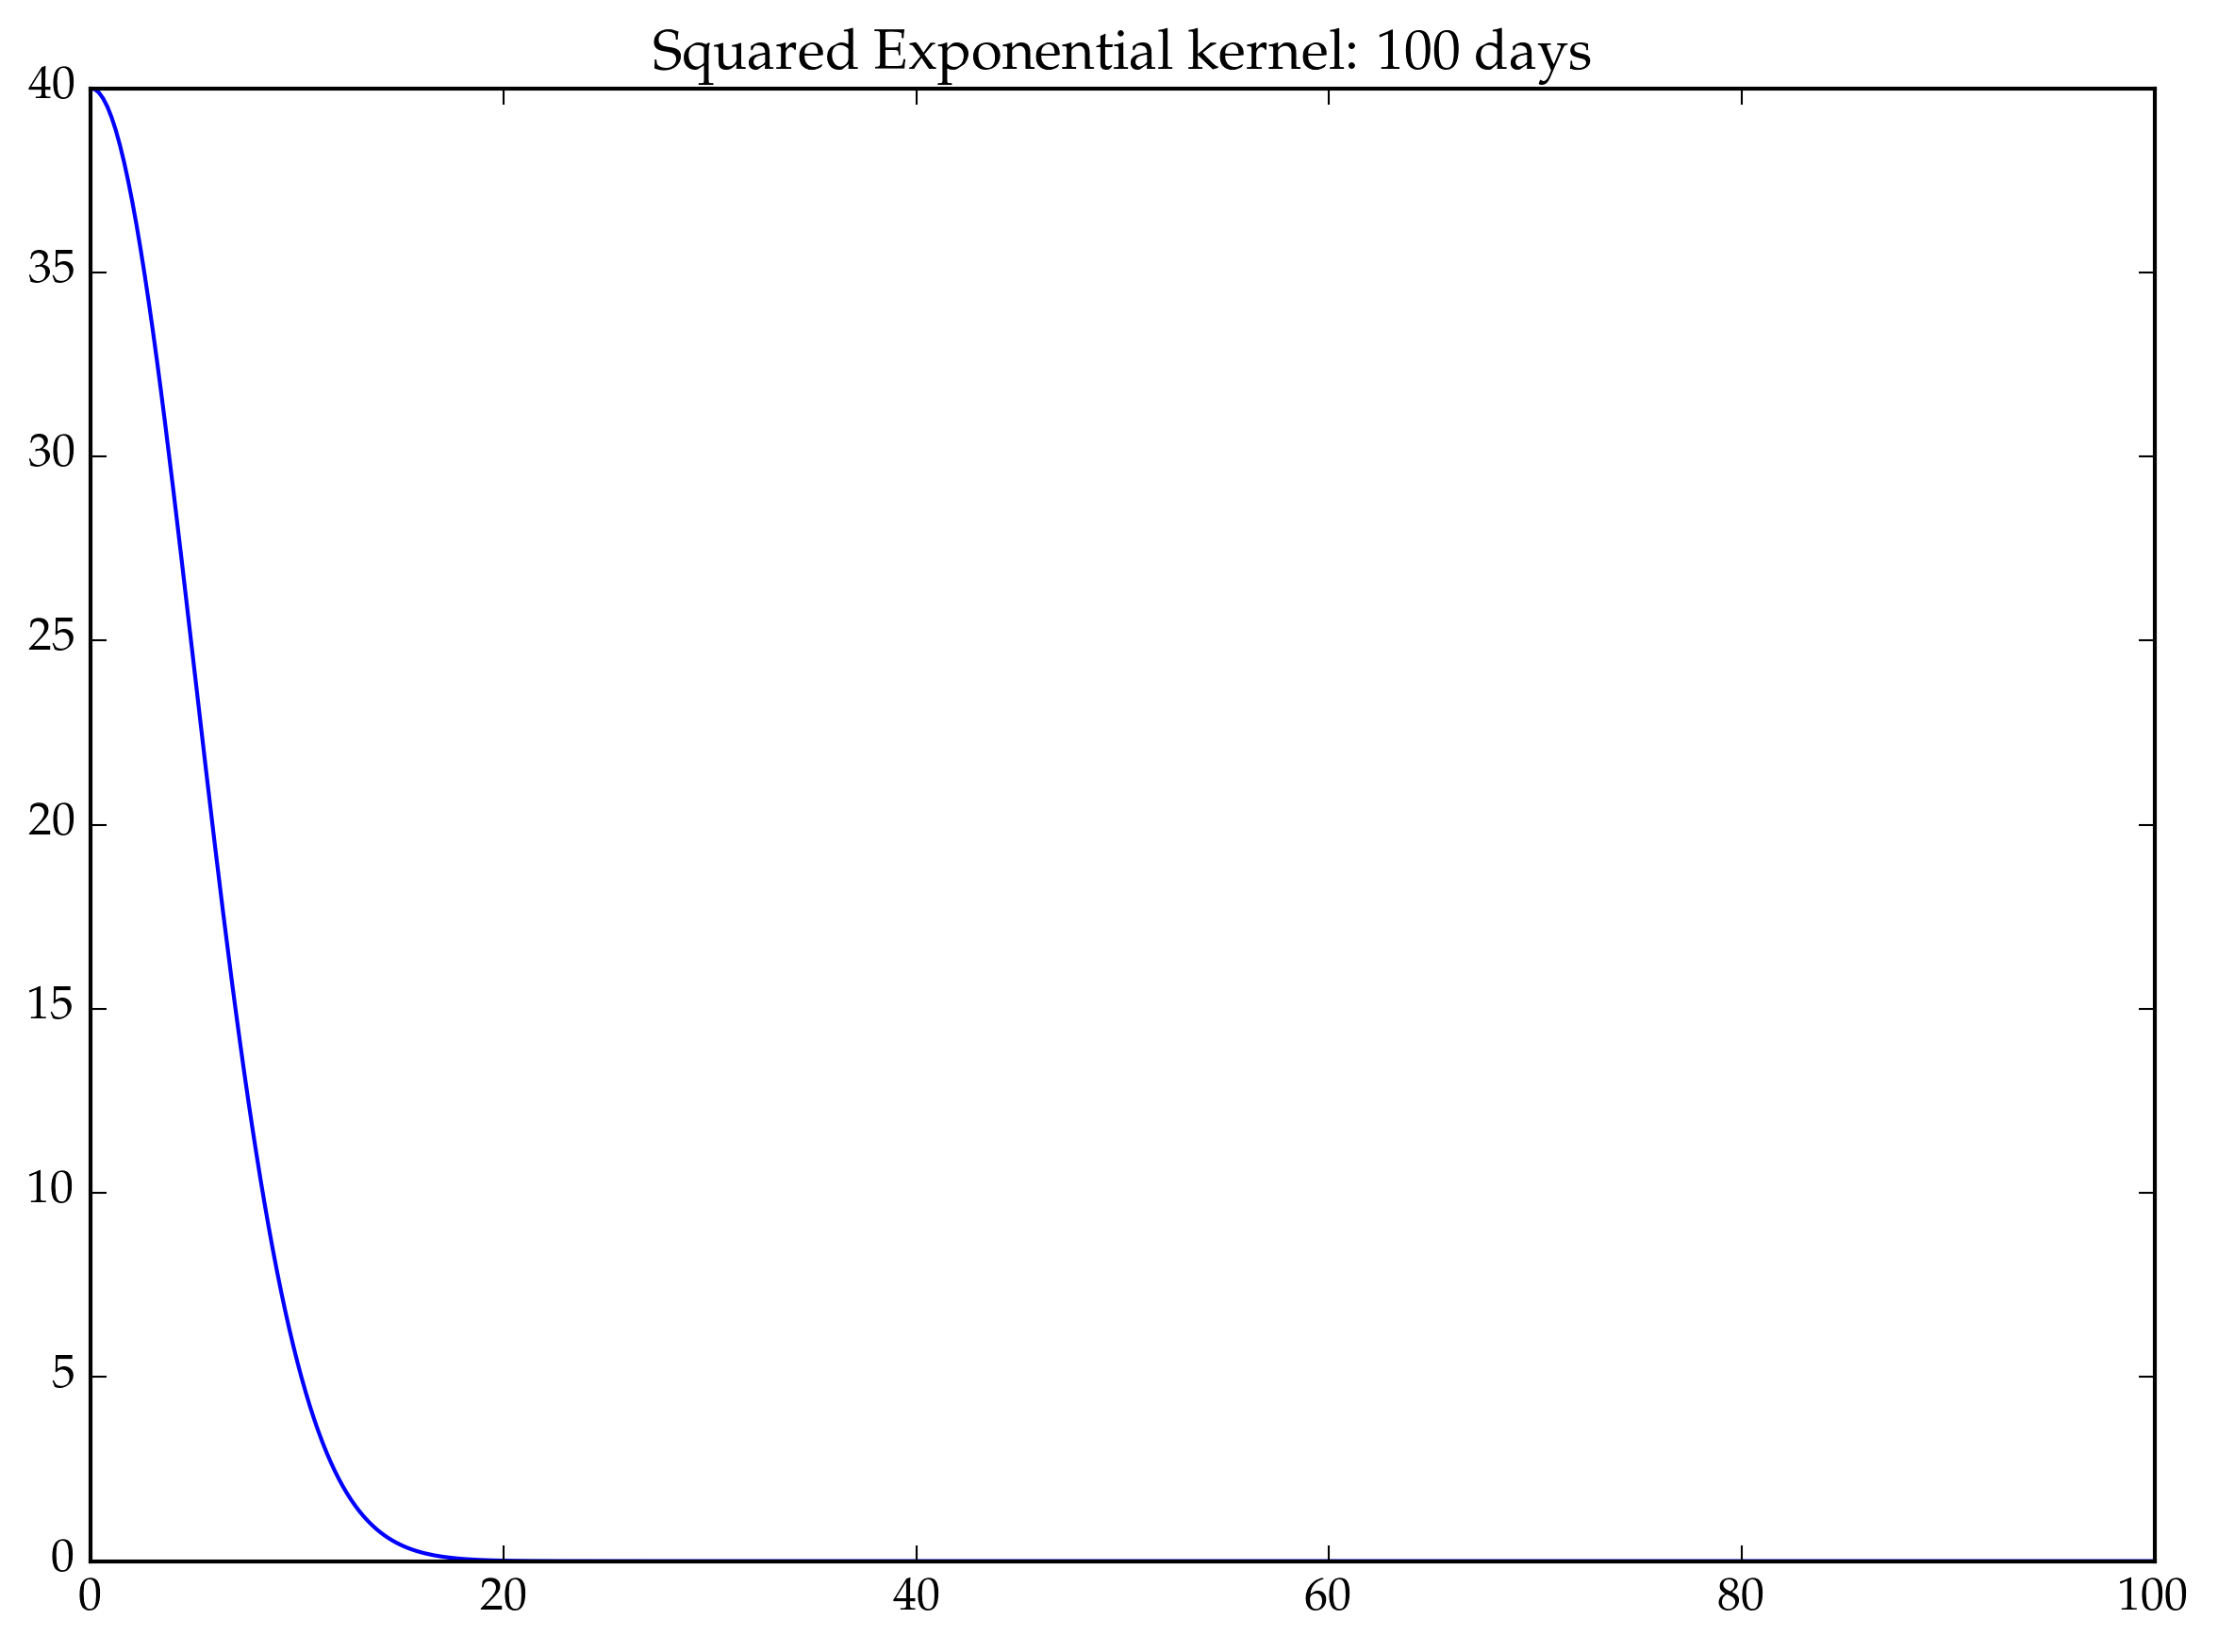

In [18]:
_x = linspace(0,24*200,1000)
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), k2))
plt.xlim(0,100)
plt.title("Squared Exponential kernel: 100 days")
;

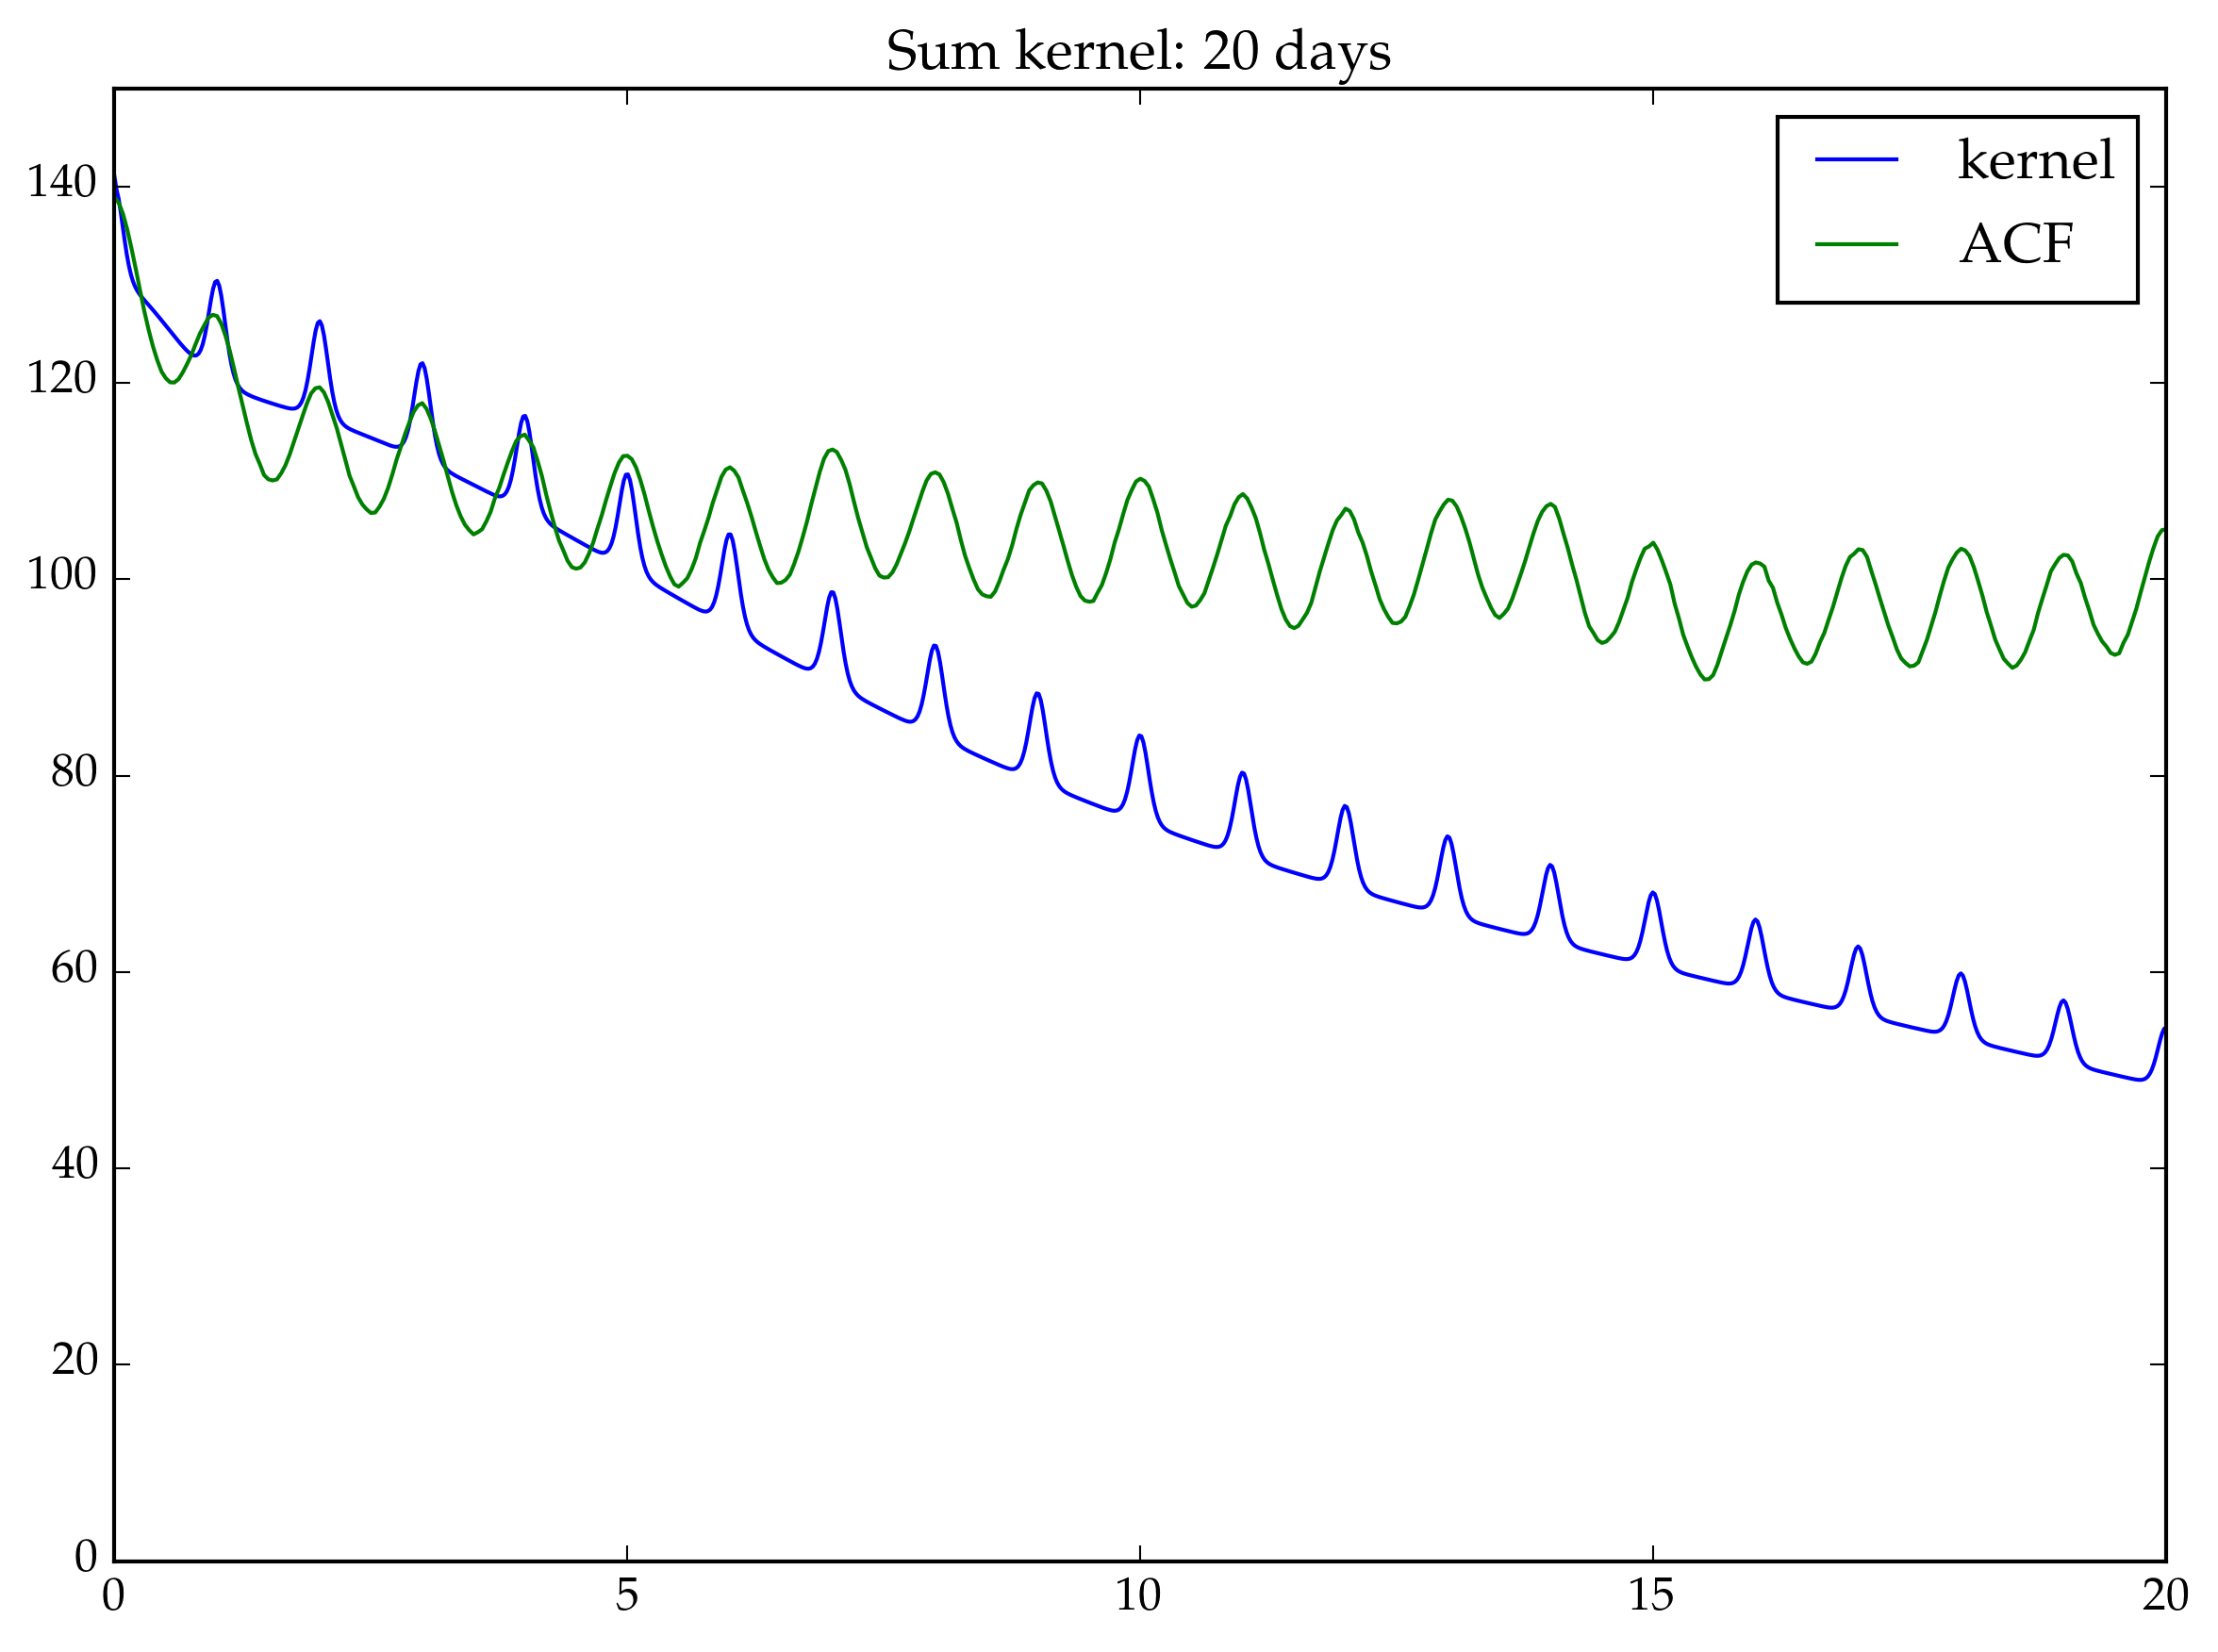

In [19]:
_days=20
_x = linspace(0,24*_days,1000)
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), _k), label="kernel")
plt.plot(bins_days, station_ACF, label="ACF")
plt.xlim(0,_days)
plt.ylim(0,150)
plt.legend(loc="best")
plt.title(@sprintf("Sum kernel: %s days", _days))
;

## Optimization ACF

In [20]:
get_free_vars{K<:GP.Kernel}(k::K, fixed_vars::Vector{Int}) = filter(i -> i ∉ fixed_vars, 1:GP.num_params(k))

function gen_optim_target{K<:GP.Kernel}(k::K, fixed_vars::Vector{Int}, days::Int)
    free_vars = get_free_vars(k, fixed_vars)
    function f(x::Array)
        y = station_ACF[1:24*days]
        tt = bins_hours[1:24*days]
        pars = GP.get_params(k)
        pars[free_vars] = x
        GP.set_params!(k, pars)
        t_arr = reshape(tt, (1,length(tt)))
        zero_arr = zeros(Float64, 1,1)
        kx = GP.crossKern(t_arr, zero_arr, k)
        loss = sum((y.-kx).^2)
    end
    function fg!(x::Array, storage::Array)
        y = station_ACF[1:24*days]
        tt = bins_hours[1:24*days]
        pars = GP.get_params(k)
        pars[free_vars] = x
        GP.set_params!(k, pars)
        t_arr = reshape(tt, (1,length(tt)))
        zero_arr = zeros(Float64, 1,1)
        kx = GP.crossKern(t_arr, zero_arr, k)
        loss = sum((y.-kx).^2)
        storage[:] = 0.0
        for (i,t) in enumerate(tt)
            storage[:] .+= GP.grad_kern(k, [0.0], [t])[free_vars] * (kx[i]-y[i])
        end
        storage[:] .*= 2
        return loss
    end
    function g!(x::Array, storage::Array)
        fg!(x,storage)
        return
    end
    return Optim.DifferentiableFunction(f, g!, fg!)
end
gen_optim_target(_k, [3], 30).f(GP.get_params(_k)[get_free_vars(_k, [3])])

1.1881248845987984e6

In [21]:
dldθ = zeros(Float64, GP.num_params(_k)-1)
println(gen_optim_target(_k, [3], 10).fg!(GP.get_params(_k)[get_free_vars(_k, [3])], dldθ))
dldθ

38023.42536368899


11-element Array{Float64,1}:
  -9259.05     
 -13510.2      
 -90904.2      
 -43642.8      
   -461.51     
     -4.80273e5
    650.757    
    756.304    
      8.47473  
 -53059.8      
     -5.36661e5

Check derivatives are correct:

In [22]:
_x = GP.get_params(_k)[get_free_vars(_k, [3])]
_x[6] += 1/dldθ[6]/10
gen_optim_target(_k, [3], 10).f(_x)

38023.52536391394

In [23]:
GP.ConstKernel

GaussianProcesses.ConstKernel

In [24]:
k0 = GP.Noise(log(√(station_ACF[1]-station_ACF[2])))
k1 = GP.Periodic(log(0.5), log(√(10.0)), log(24.0))
k2 = GP.RQIso(log(0.1*24), log(√10.0), 3.0) # short term
k3 = GP.RQIso(log(3.0*24), log(√20.0), 3.0)
k4 = GP.RQIso(log(10.0*24), log(√20.0), 3.0)
k5 = GP.SE(log(200.0*24), log(√80.0))

_k=k0+k1+k2+k3+k4+k5
_n = GP.num_params(_k)
Optim.optimize(gen_optim_target(_k, [1,4,14], 3),  
    GP.get_params(_k)[get_free_vars(_k, [1,4,14])], Optim.LBFGS())
Optim.optimize(gen_optim_target(_k, [4,14], 3),  
    GP.get_params(_k)[get_free_vars(_k, [4,14])], Optim.LBFGS())    
Optim.optimize(gen_optim_target(_k, [4,5,6,7,14], 10), 
    GP.get_params(_k)[get_free_vars(_k, [4,5,6,7,14])], Optim.LBFGS())
# Optim.optimize(gen_optim_target(_k, [4,5,7,8,9,10,14], 20), 
#     GP.get_params(_k)[get_free_vars(_k, [4,5,7,8,9,10,14])], Optim.LBFGS())

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.5.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:38
 in + at operators.jl:103
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /Users/imolk/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /Users/imolk/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[24], in expression starting on line 8
 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.5.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:38
 in afoldl at operators.jl:84
 in + at operators.jl:103
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /Users/imolk/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /Users/imolk/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[24], in expression starting on line 8
 in depwarn at depre

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-0.5806037948489204,0.688245576256138, ...]
 * Minimizer: [-5.791552097235005,0.7497261786981005, ...]
 * Minimum: 1.229242e+02
 * Iterations: 131
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 913
 * Gradient Calls: 913

In [25]:
_k

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.Noise, Params: [-5.791552097235005]
  Type: GaussianProcesses.Periodic, Params: [0.7497261786981005,1.7535943675513224,3.1780538303479458]
  Type: GaussianProcesses.RQIso, Params: [1.6585767371687814,0.7208158985970418,26.196951320134794]
  Type: GaussianProcesses.RQIso, Params: [2.792056254090819,1.161013240660209,27.619026754096065]
  Type: GaussianProcesses.RQIso, Params: [3.973564212407257,1.3823399367539142,-0.054458358178104564]
  Type: GaussianProcesses.SEIso, Params: [8.476371196895983,2.161004700695647]


In [26]:
sqrt(k2.ℓ2)/24,sqrt(k3.ℓ2)/24,sqrt(k4.ℓ2)/24,sqrt(k5.ℓ2)/24

(0.2188262827962769,0.679772173271285,2.215571496229019,200.00000000000003)

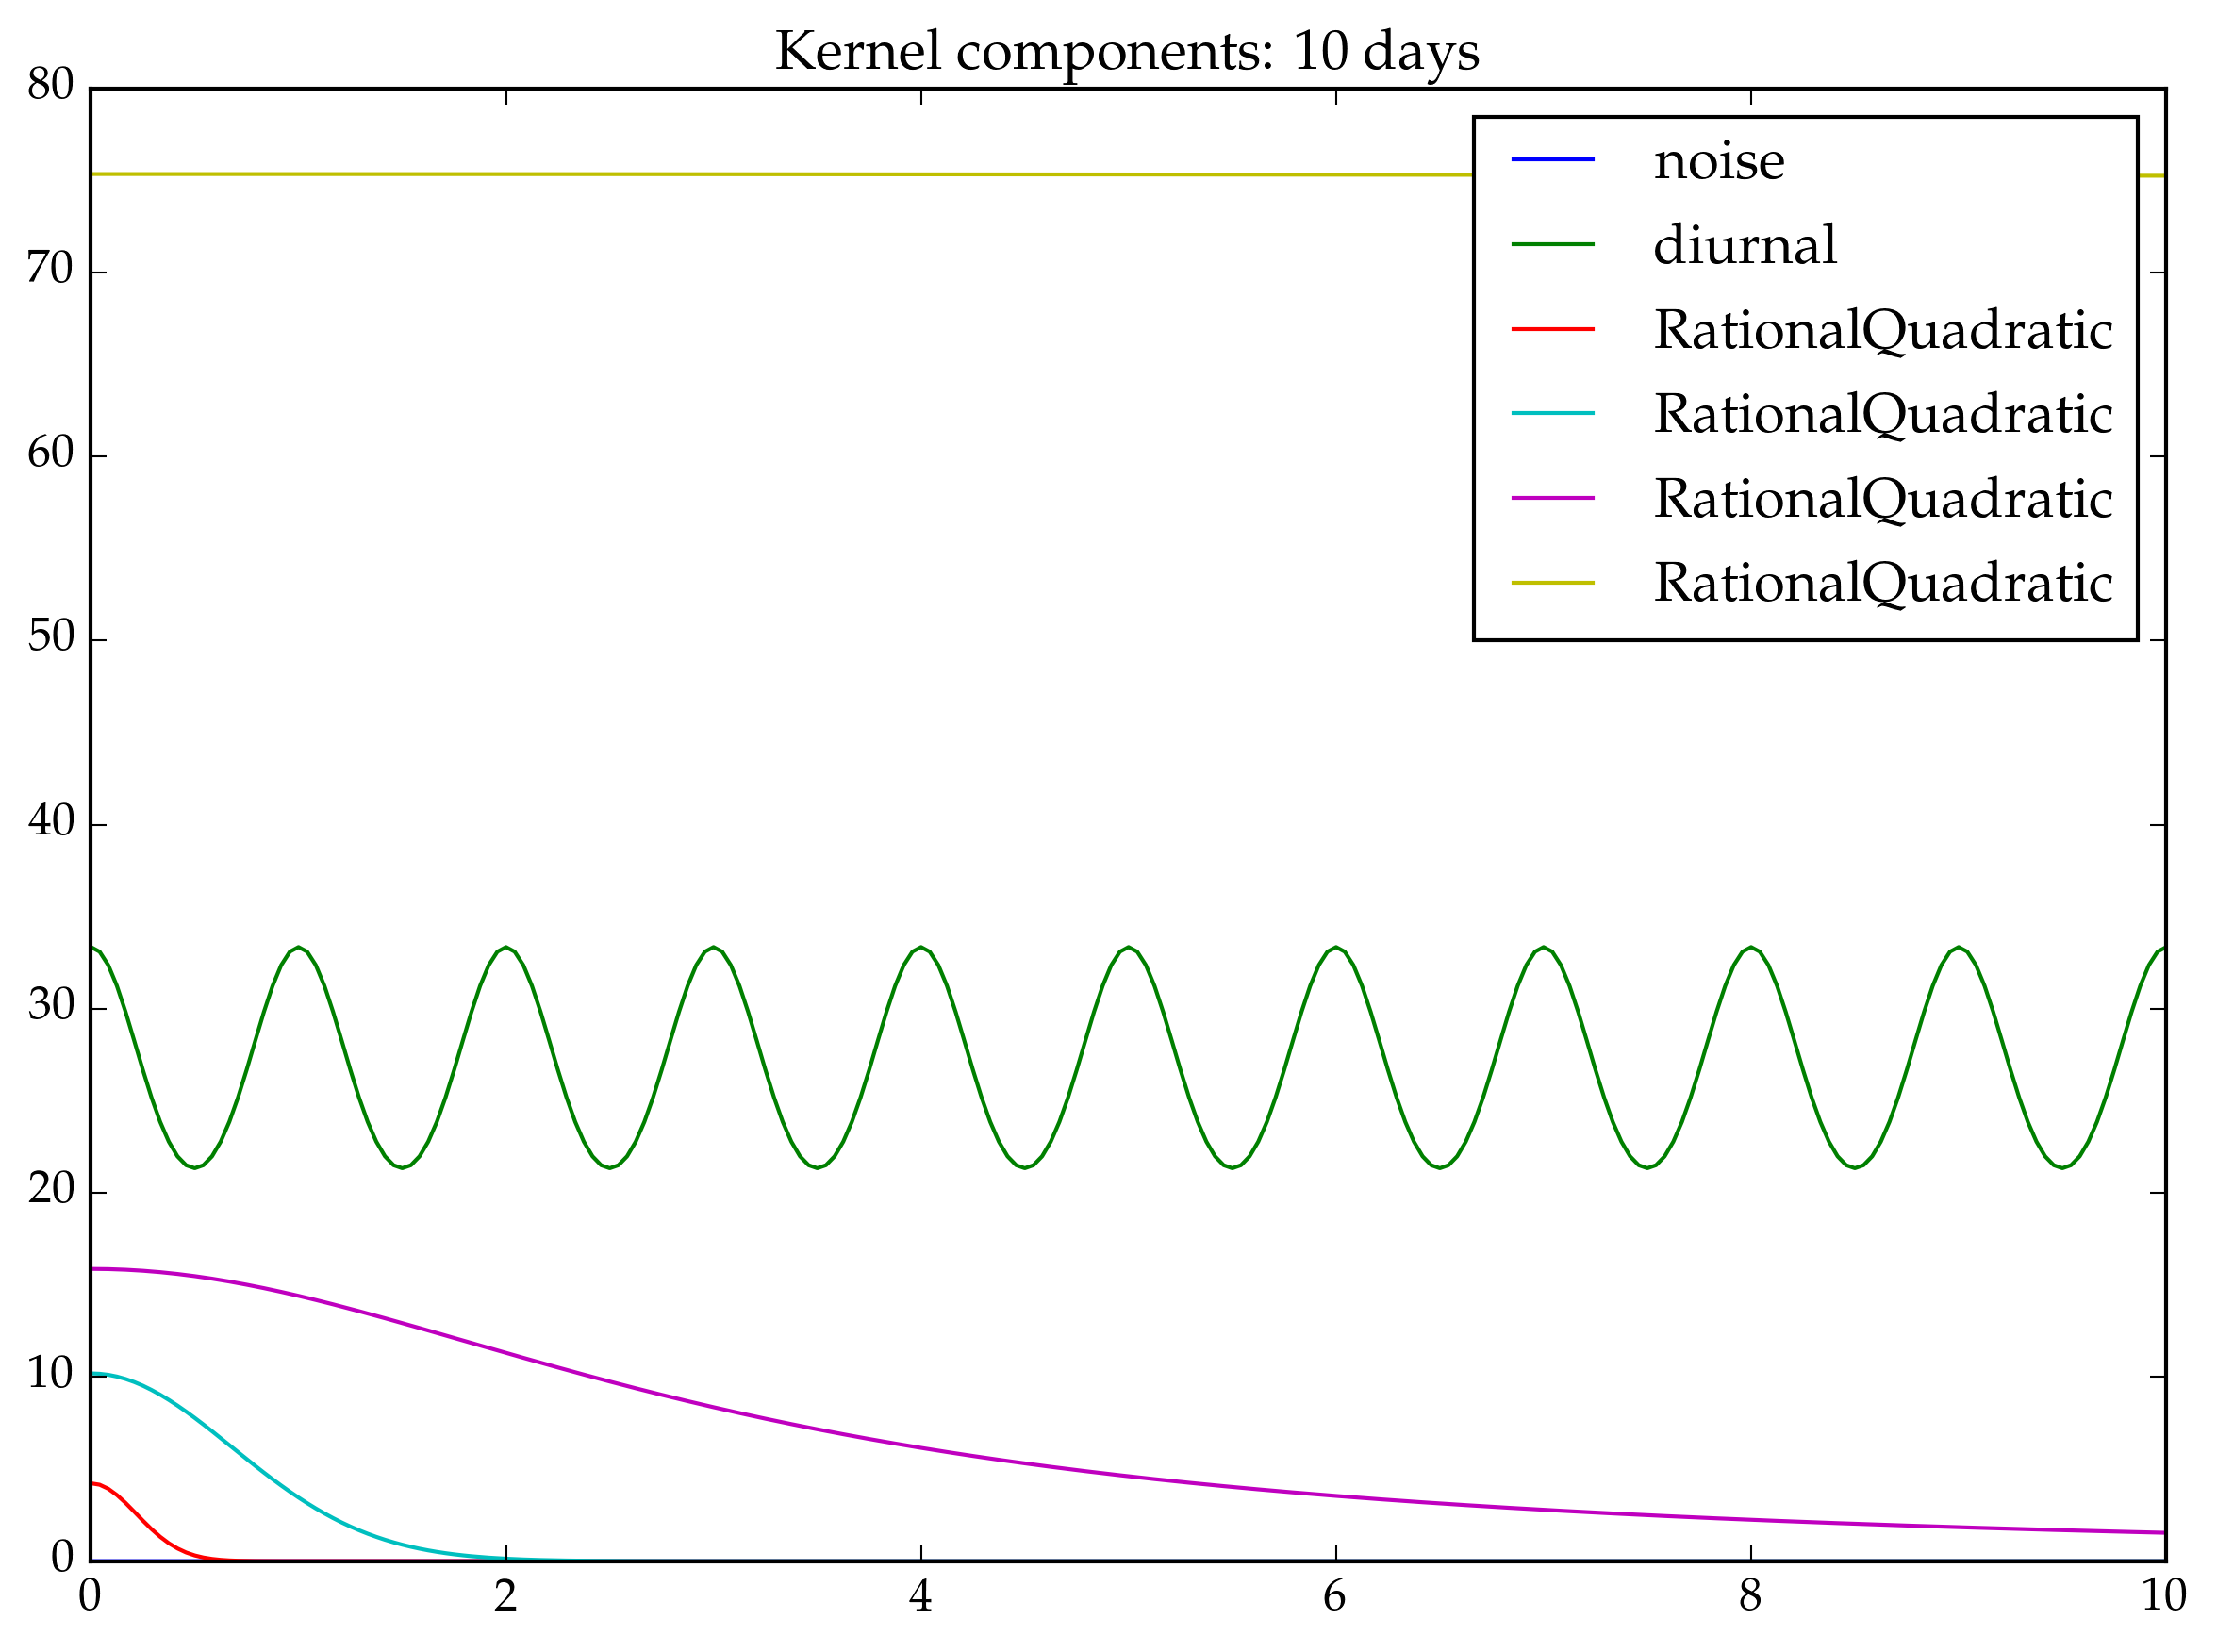

In [27]:
_ndays = 10
_x = collect(0:24.0*_ndays)
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), k0), label="noise")
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), k1), label="diurnal")
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), k2), label="RationalQuadratic")
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), k3), label="RationalQuadratic")
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), k4), label="RationalQuadratic")
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), k5), label="RationalQuadratic")
plt.xlim(0,_ndays)
plt.legend(loc="upper right")
plt.title(@sprintf("Kernel components: %s days", _ndays))
;

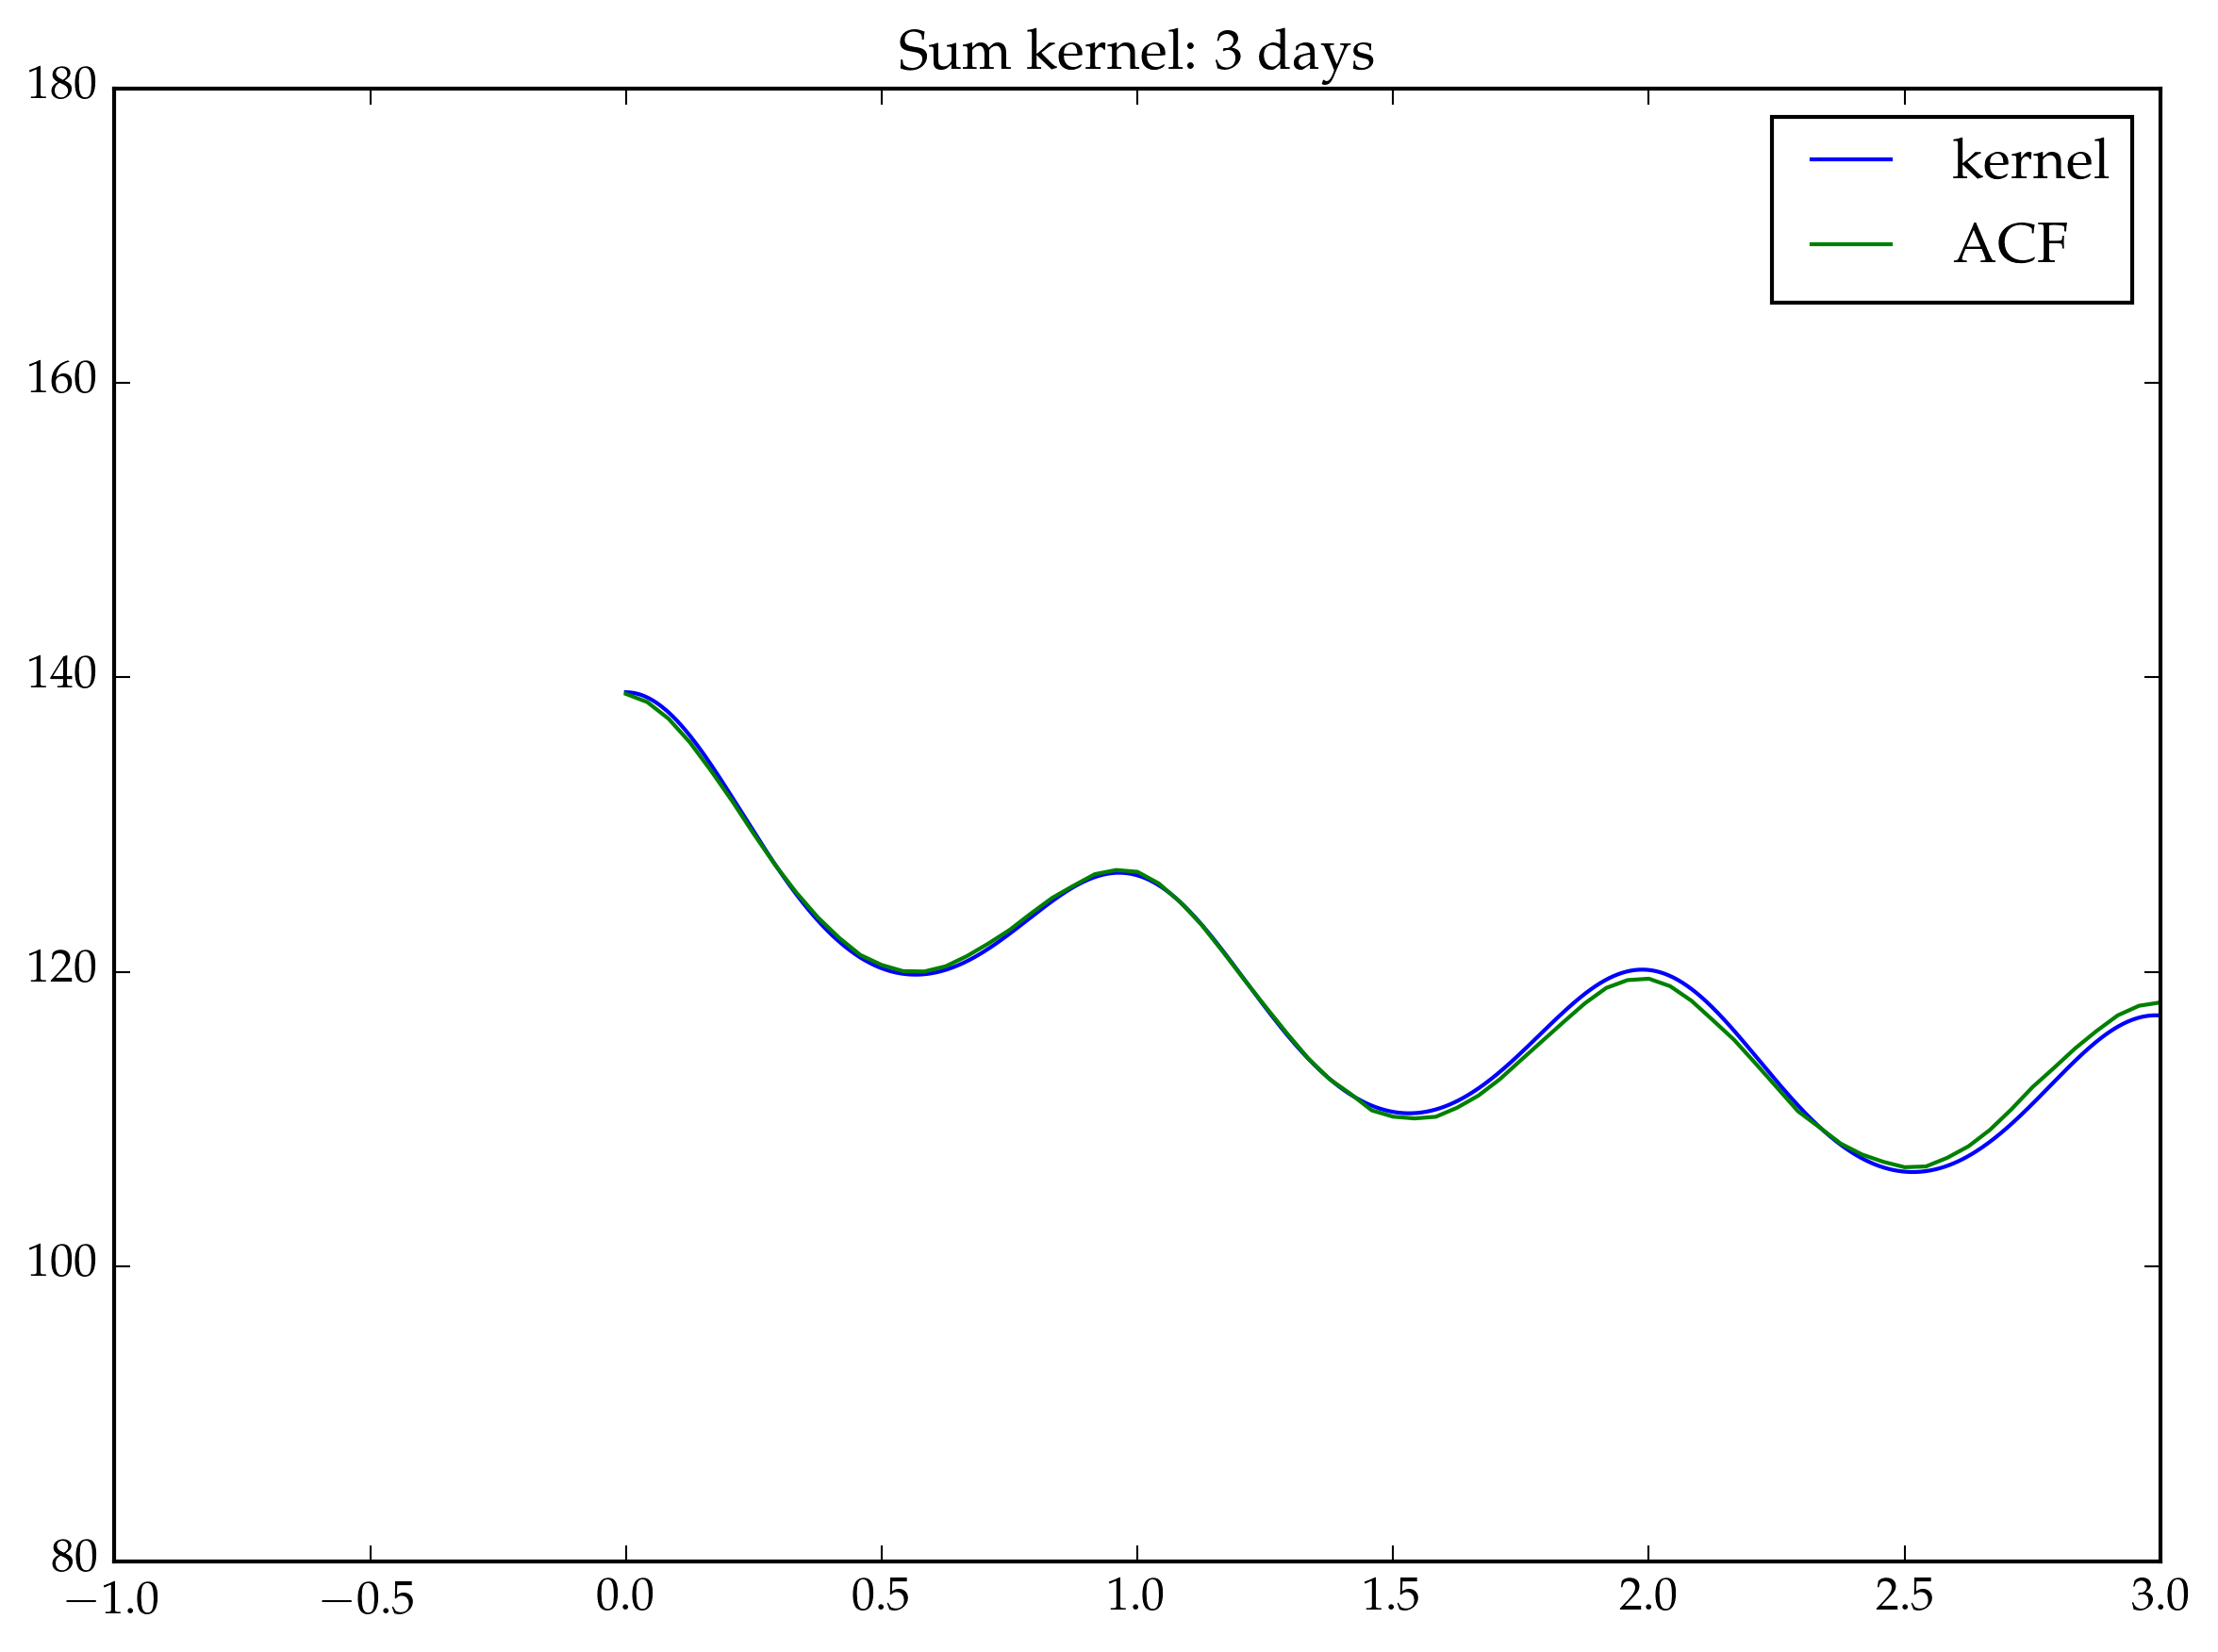

In [28]:
_days=3
_x = linspace(0,24*_days,1000)
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), _k), label="kernel")
plt.plot(bins_days, station_ACF, label="ACF")
plt.xlim(-1,_days)
plt.ylim(80,180)
plt.legend(loc="best")
plt.title(@sprintf("Sum kernel: %s days", _days))
;

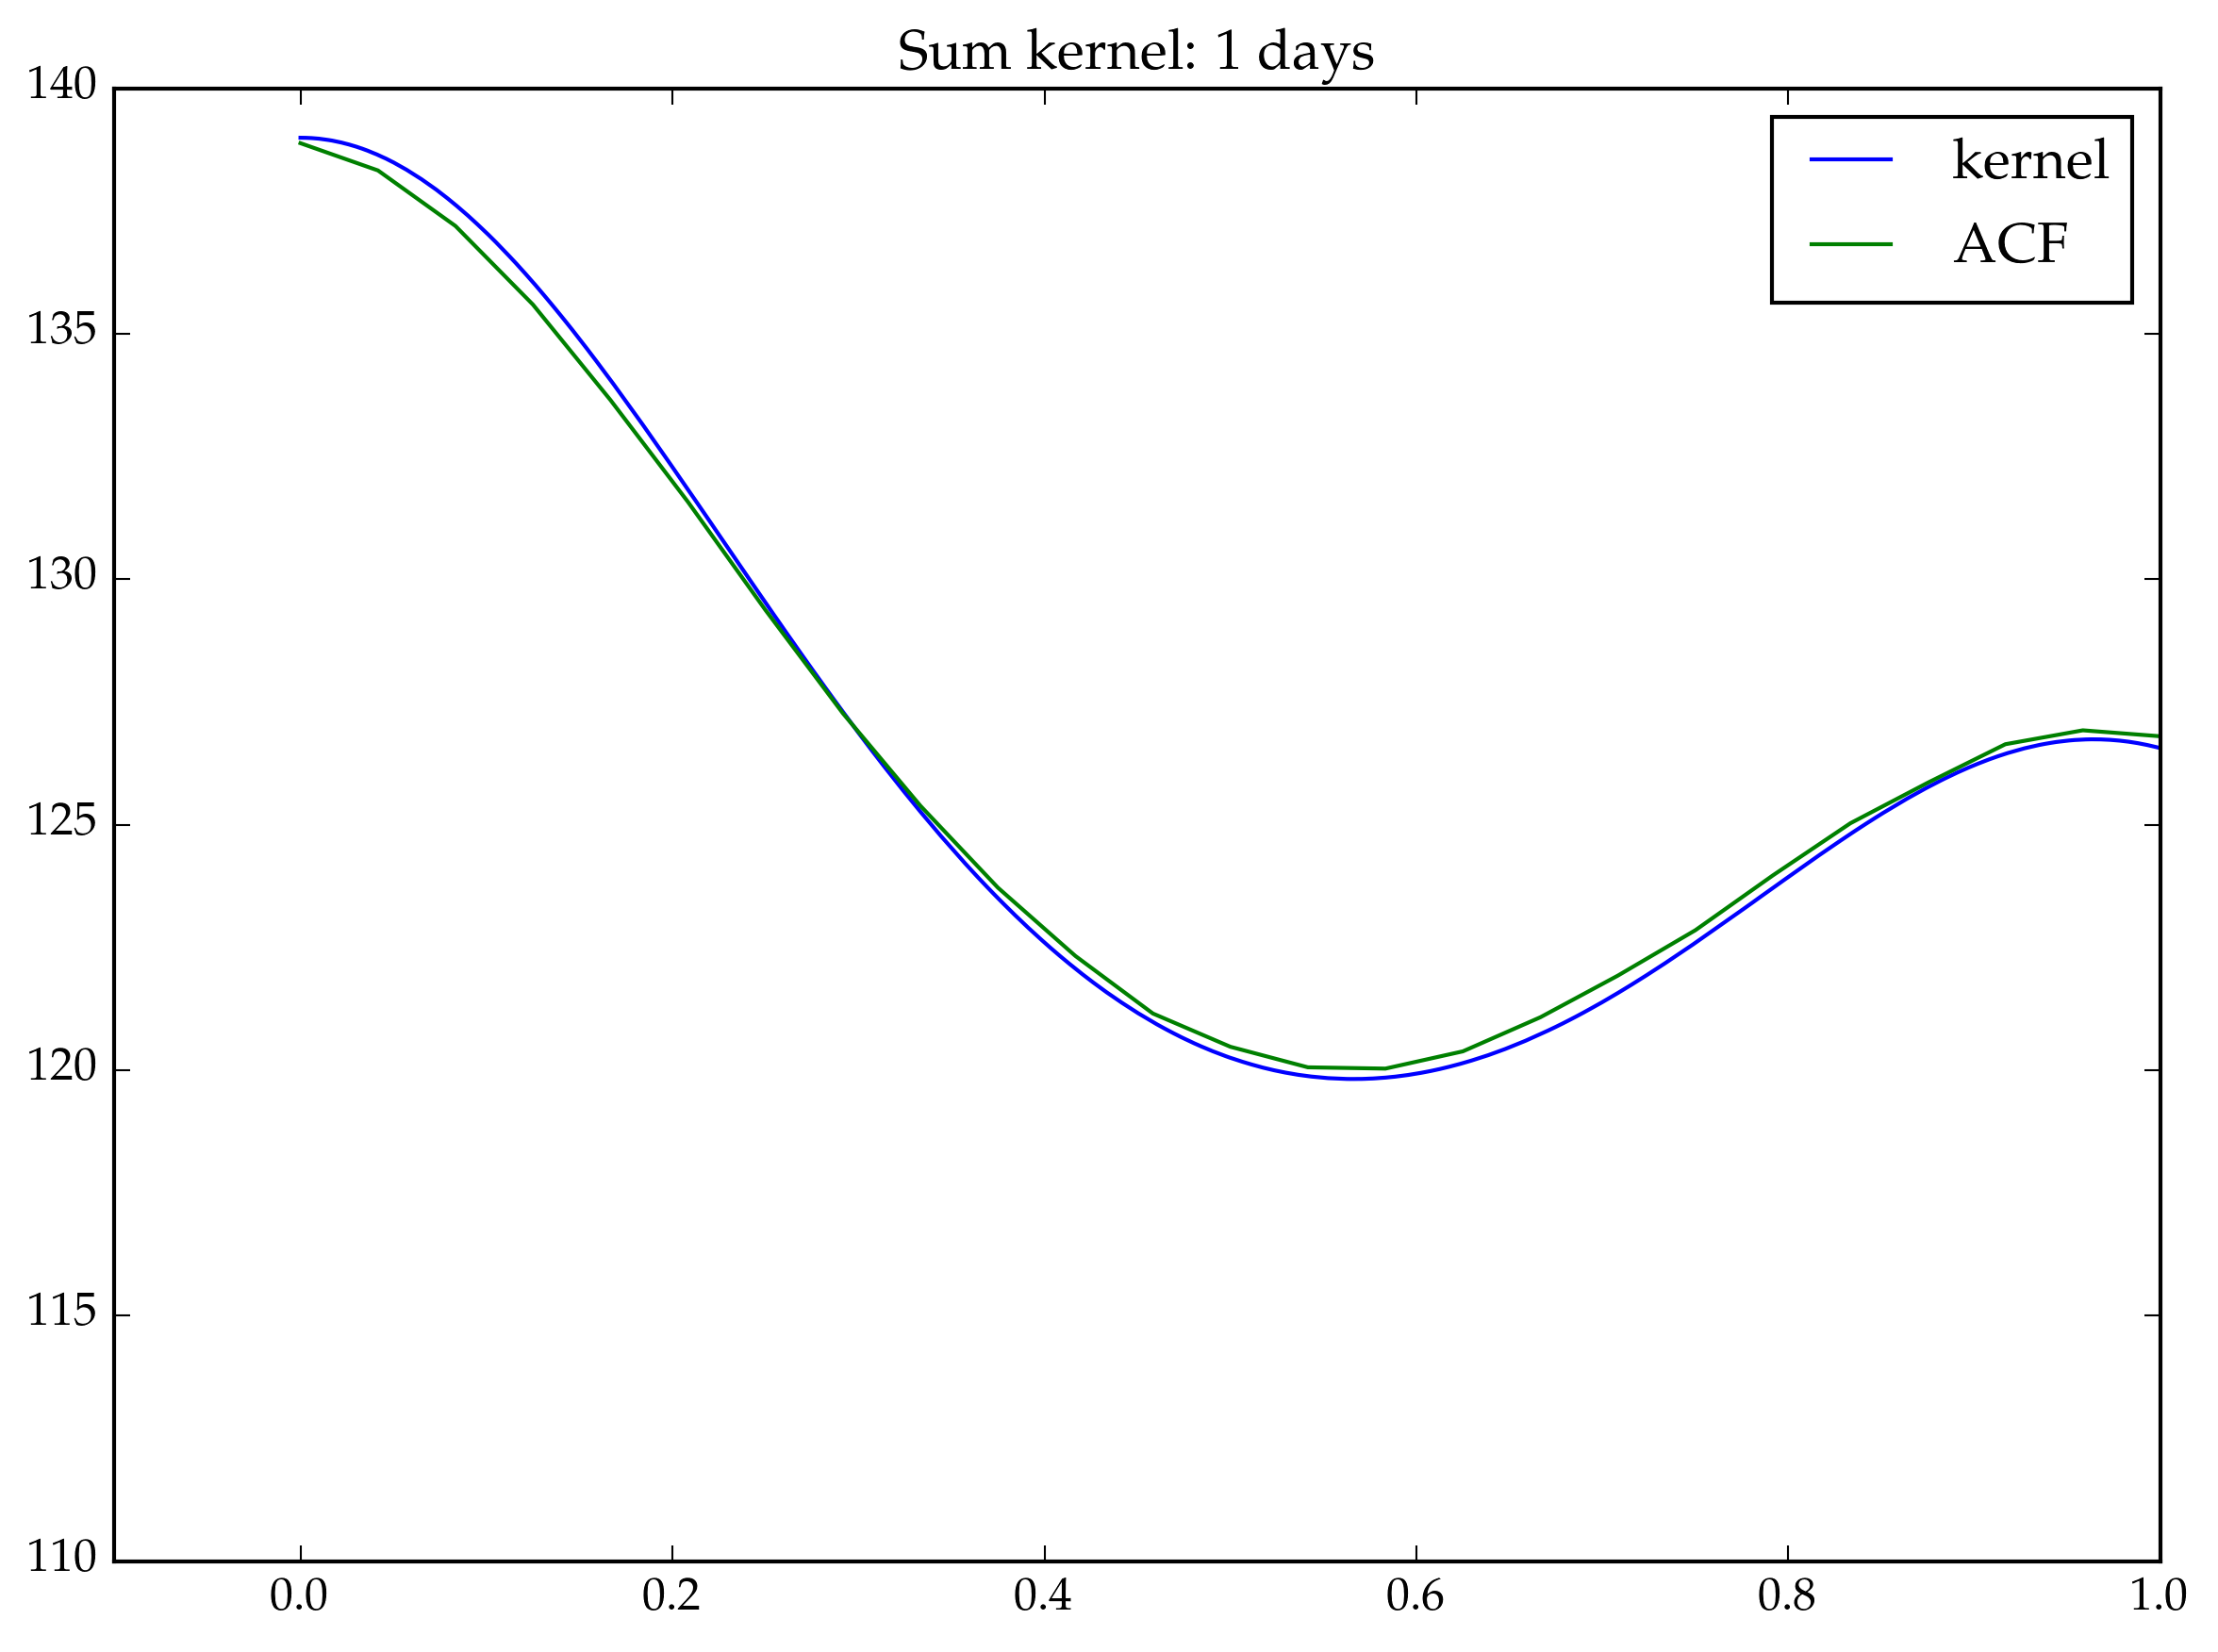

In [29]:
_days=1
_x = linspace(0,24*_days,1000)
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), _k), label="kernel")
plt.plot(bins_days, station_ACF, label="ACF")
plt.xlim(-0.1,_days)
plt.ylim(110,140)
plt.legend(loc="best")
plt.title(@sprintf("Sum kernel: %s days", _days))
;

In [30]:
Optim.optimize(gen_optim_target(_k, [3], 50), GP.get_params(_k)[get_free_vars(_k, [3])], Optim.LBFGS())

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-5.791552097235005,0.7497261786981005, ...]
 * Minimizer: [-5.791548513535131,0.7280797357851593, ...]
 * Minimum: 4.926799e+03
 * Iterations: 39
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 265
 * Gradient Calls: 265

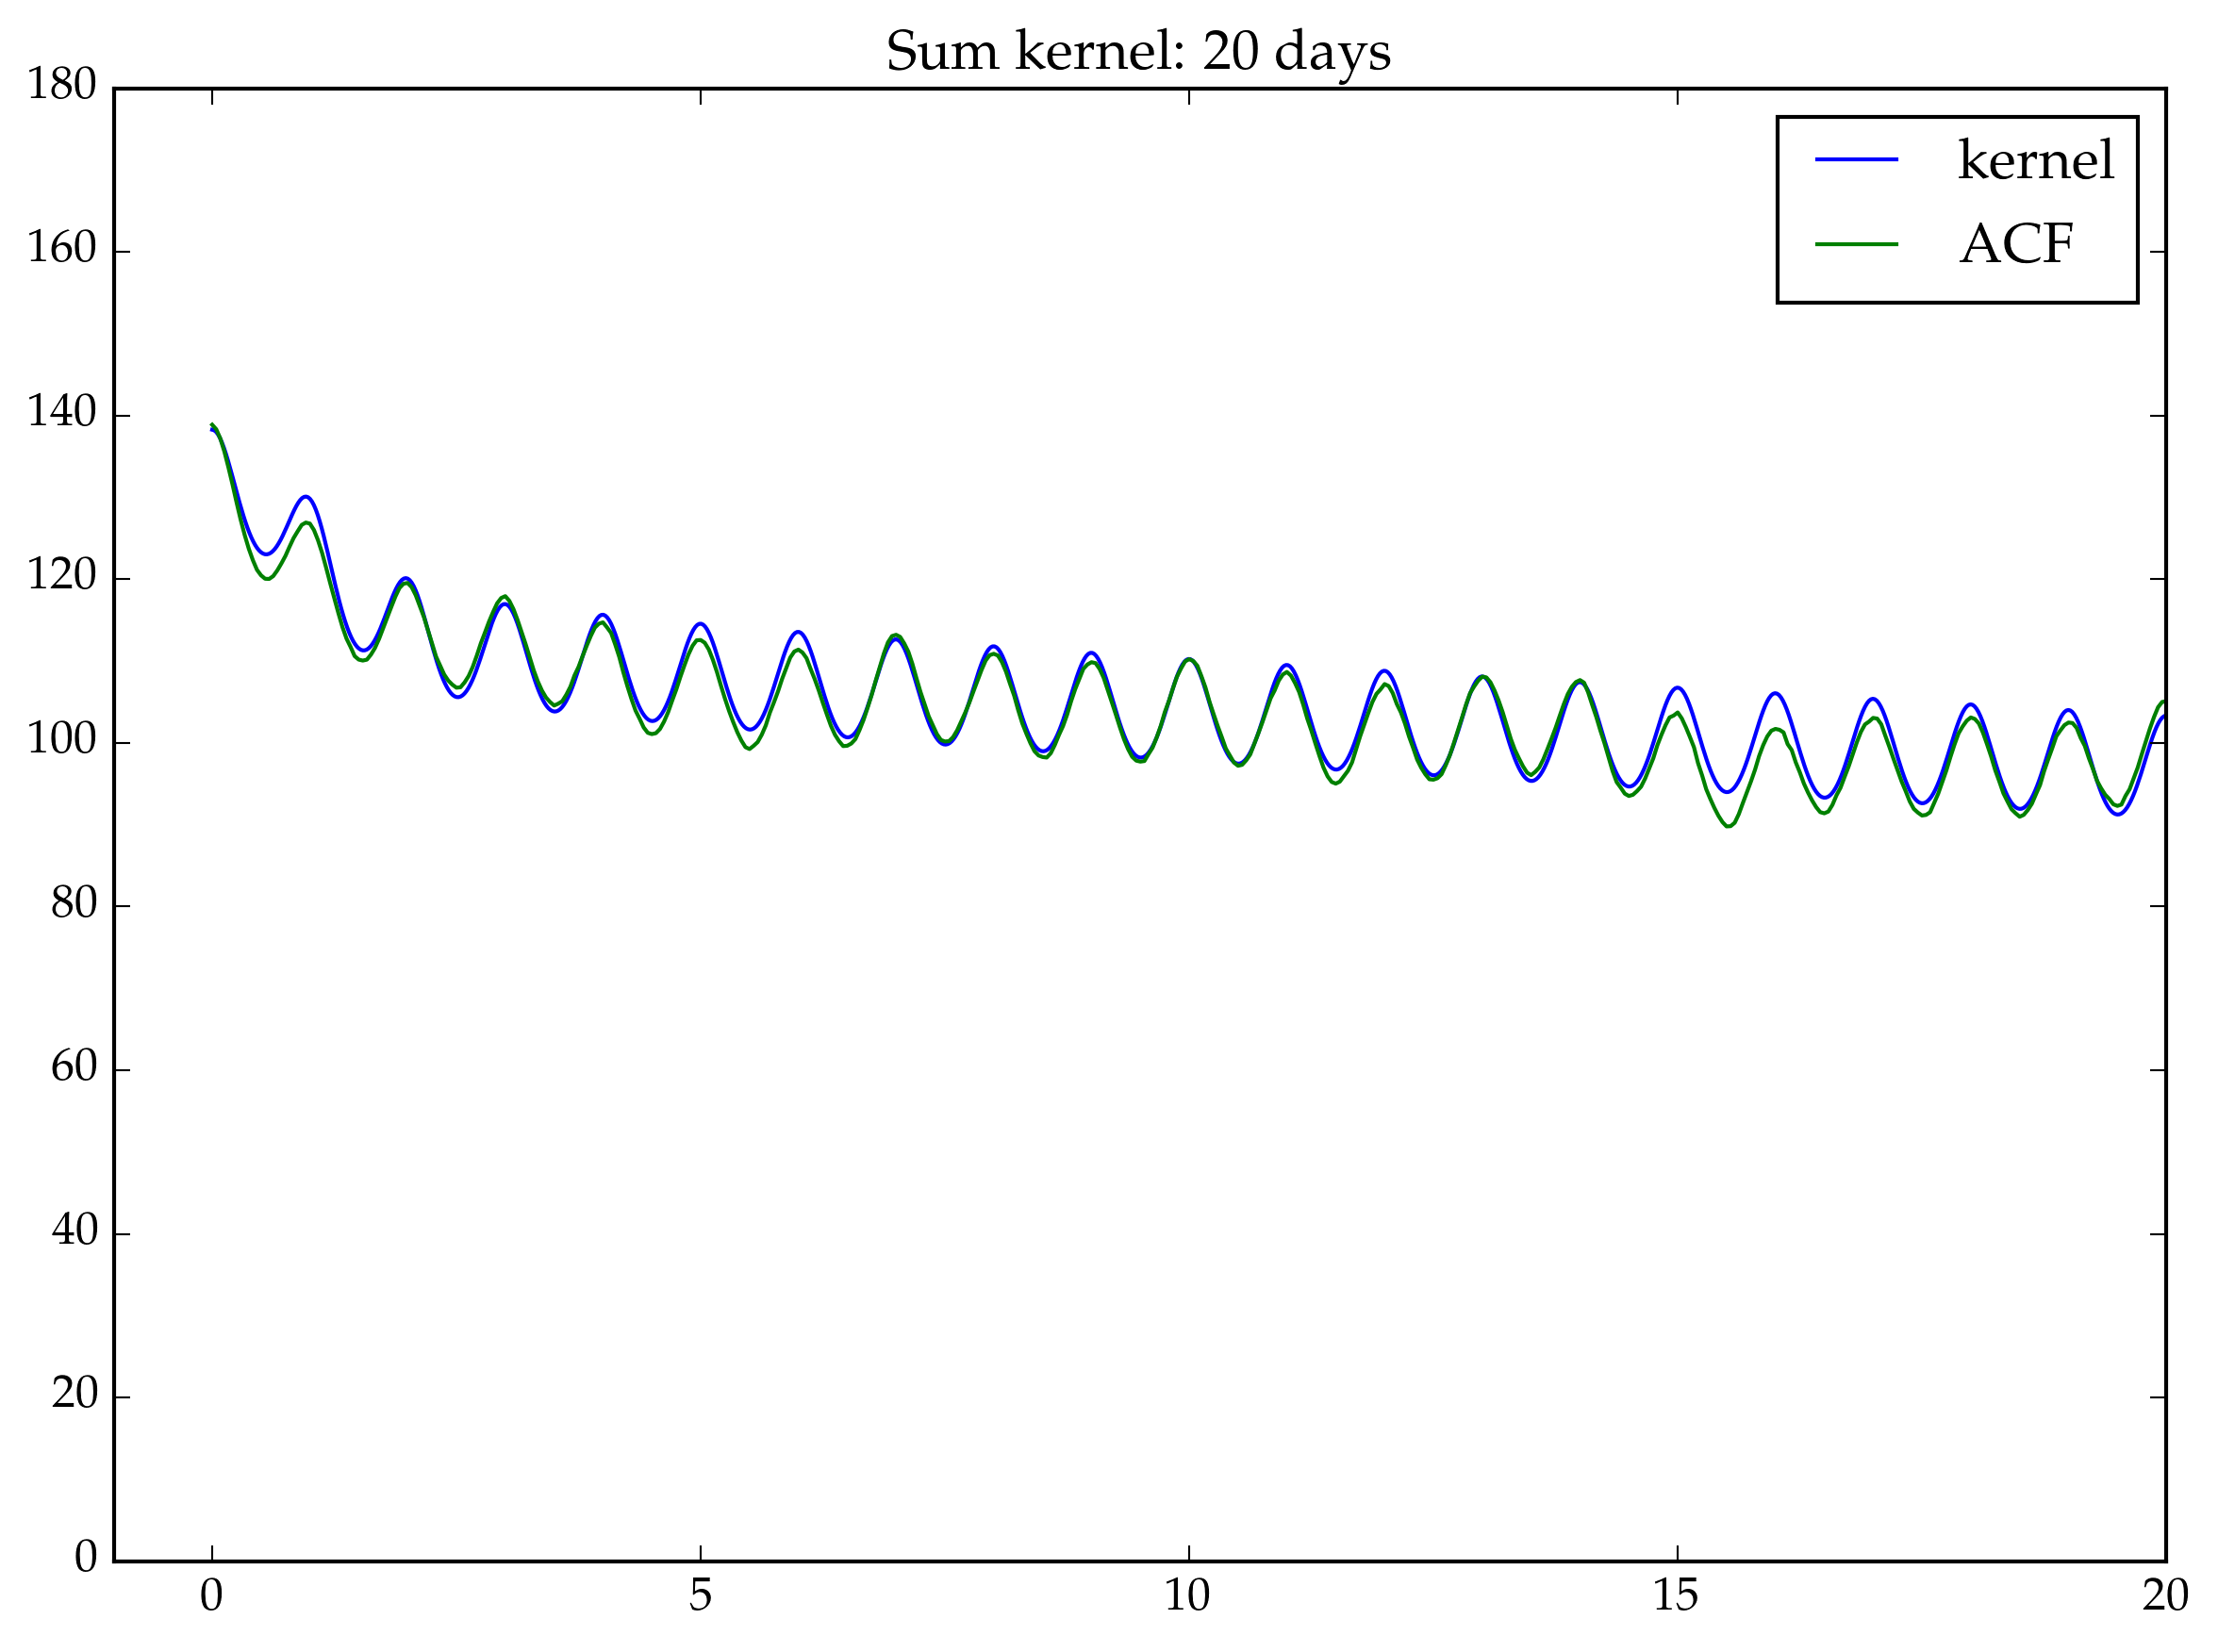

In [31]:
_days=20
_x = linspace(0,24*_days,1000)
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), _k), label="kernel")
plt.plot(bins_days, station_ACF, label="ACF")
plt.xlim(-1,_days)
plt.ylim(0,180)
plt.legend(loc="best")
plt.title(@sprintf("Sum kernel: %s days", _days))
;

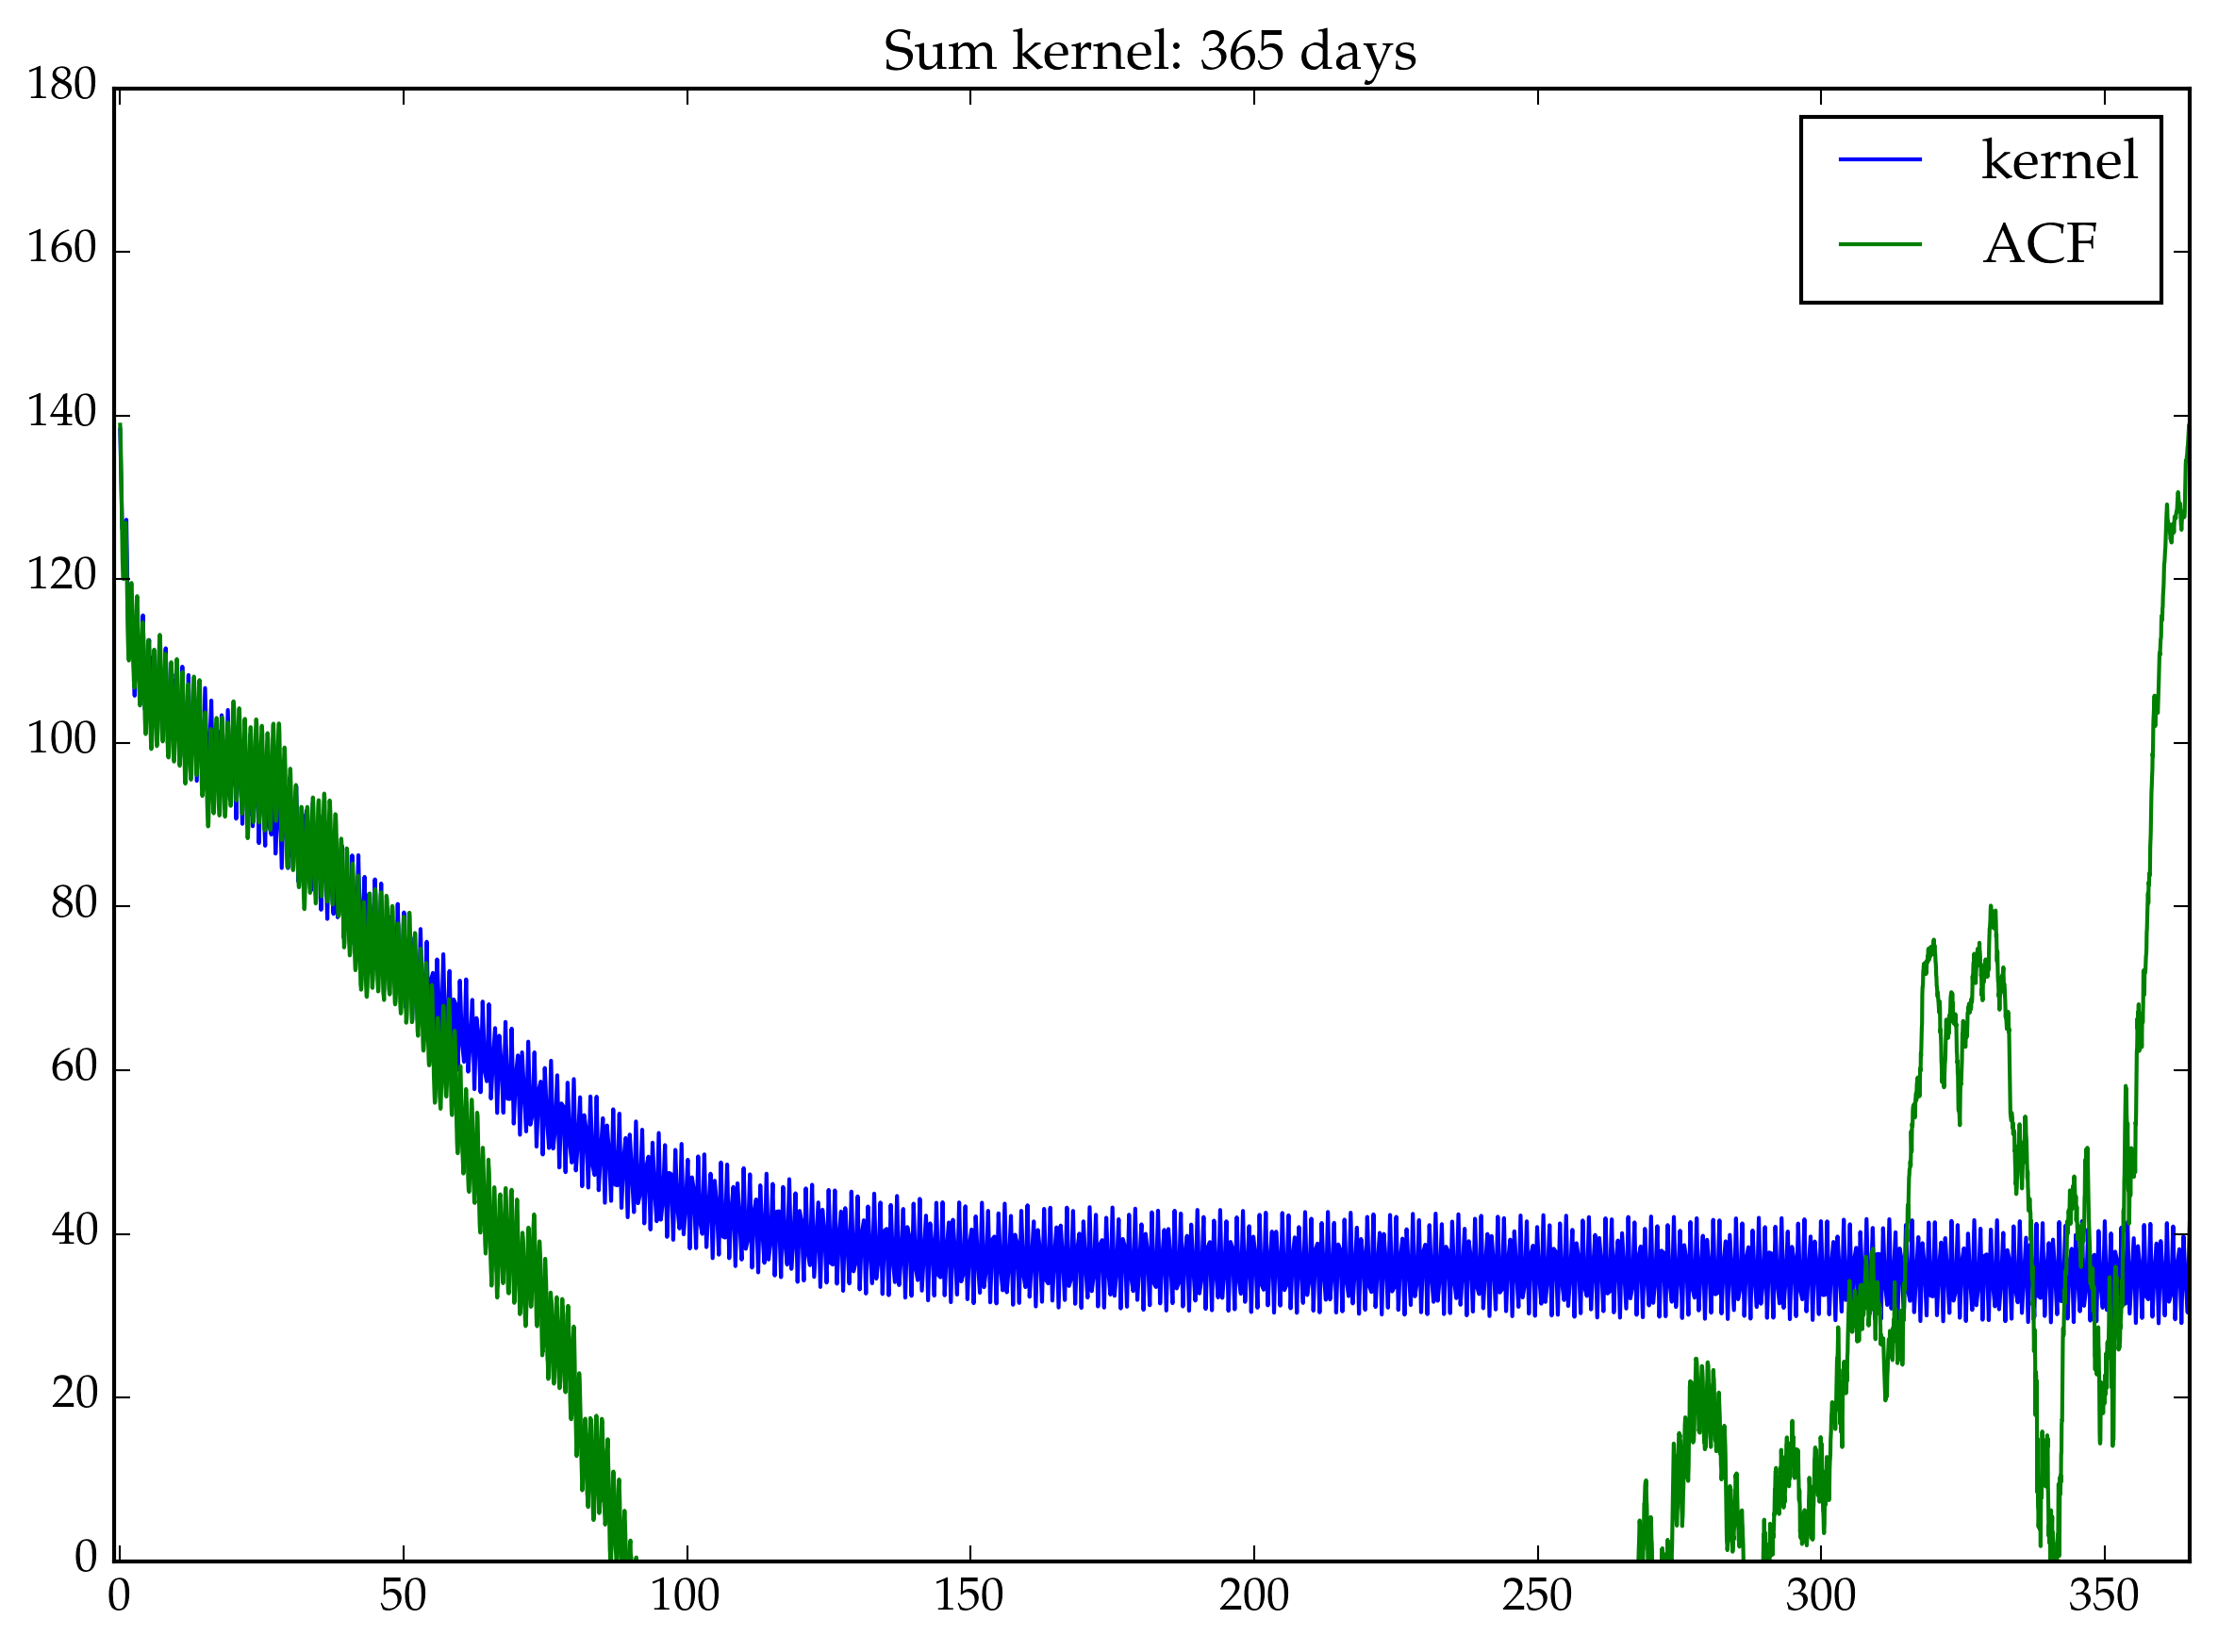

In [32]:
_days=365
_x = linspace(0,24*_days,1000)
plt.plot(_x/24, GP.crossKern(reshape(_x, (1,length(_x))), zeros(Float64, 1,1), _k), label="kernel")
plt.plot(bins_days, station_ACF, label="ACF")
plt.xlim(-1,_days)
plt.ylim(0,180)
plt.legend(loc="best")
plt.title(@sprintf("Sum kernel: %s days", _days))
;

# Fitting GP

In [33]:
ms_per_hour = 1e3*3600
ts_vec = convert(Vector{Float64}, station_ts.-station_ts[1]) / ms_per_hour
ts_arr = reshape(ts_vec, (1,length(ts_vec)))

1x11118 Array{Float64,2}:
 0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  …  8756.0  8757.0  8758.0  8759.0

In [34]:
_k_nonoise = (k1+k2+k3+k4+k5)
_k_nonoise

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.5.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:38
 in + at operators.jl:103
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /Users/imolk/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /Users/imolk/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[34], in expression starting on line 1
 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.5.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:38
 in + at operators.jl:103
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /Users/imolk/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /Users/imolk/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[34], in expression starting on line 1
 in depwarn at deprecated.jl:73
 in oldstyle_vcat_

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.Periodic, Params: [0.7280797357851593,1.7535943675513224,3.178095640168996]
  Type: GaussianProcesses.RQIso, Params: [3.12500197531486,1.4674123768092893,26.196665999078036]
  Type: GaussianProcesses.RQIso, Params: [6.998833815396973,0.7325633239515321,27.62323422724019]
  Type: GaussianProcesses.RQIso, Params: [4.933829378526913,1.6712552748095482,-2.0428091828404695]
  Type: GaussianProcesses.SEIso, Params: [7.03042177289389,1.989649778167361]


In [35]:
k0
_lognoise = 2k0.lσ

-11.583097027070261

In [36]:
mean_func = GP.MeanConst(mean(station_data[:temp]))
temp_vec = convert(Vector{Float64}, station_data[:temp])
gp_fit = GP.GP(ts_arr, temp_vec, mean_func, _k_nonoise, -9.0)

LoadError: LoadError: Base.LinAlg.PosDefException(5)
while loading In[36], in expression starting on line 3

In [37]:
function plot1D(gp::GP.GP; clim::Tuple{Float64, Float64}=(minimum(gp.x), maximum(gp.x)), CI::Float64=1.96, res::Int=1000)

        sx = (clim[2]-clim[1])/(res-1)
        x=collect(clim[1]:sx:clim[2])
        mu, Sigma = GP.predict(gp, x)
        conf = CI*sqrt(Sigma)
        u = mu + conf
        l = mu - conf
        
        plt.plt[:interactive](true)
        plt.title("GP")
        plt.plt[:interactive](false)
        plt.plot(x, mu, color="blue")
        plt.fill_between(x, u, l,
            alpha=0.3, edgecolor="none", facecolor="blue")
        plt.plt[:interactive](true)    
end

plot1D (generic function with 1 method)

In [38]:
@time GP.predict(gp_fit, collect(linspace(0,100,10)));

LoadError: LoadError: UndefVarError: gp_fit not defined
while loading In[38], in expression starting on line 155

In [39]:
_ndays=3
plt.plot(ts_vec, temp_vec, ".-", color="#555555", label="data")
@time plot1D(gp_fit, clim=(0.0,24.0*_ndays), res=100)
plt.xlim(0,24*_ndays)
;

LoadError: LoadError: UndefVarError: gp_fit not defined
while loading In[39], in expression starting on line 155